---

### **TASK 2.1: MODEL TRAINING & BASELINE EXPERIMENTATION**

`OBJECTIVE`: 
1. Systematically compare feature sets, balancing strategies, and algorithms
2. Identify the best baseline configuration WITHOUT hyperparameter tuning
3. Establish a reproducible ML experimentation workflow using MLflow
4. Prepare for Task 2.2 (Hyperparameter Tuning)

`METHODOLOGICAL PRINCIPLES`:
1. SCIENTIFIC METHOD: Isolate variables → test hypotheses → analyze results
2. NO TEST LEAKAGE: All decisions based on validation data only
3. REPRODUCIBILITY: Fixed random seeds, consistent evaluation pipeline
4. MLFLOW EXCELLENCE: Comprehensive logging for experiment tracking

`EXPERIMENTATION STRATEGY`:
- Phase 1: Feature Set Battle (Which consensus level works best?)
- Phase 2: Balancing Strategy (SMOTE vs Original training)
- Phase 3: Algorithm Shootout (Which model family performs best?)
- Phase 4: Threshold Analysis (Optimize for safety vs. precision)

`OUTPUTS`:
- Best feature set configuration
- Best balancing strategy  
- Best baseline algorithm
- Comprehensive MLflow experiment with all artifacts
- Handoff document for hyperparameter tuning

`PRIMARY METRIC`
- F1-score (Dangerous class)
    - Balances recall and precision. This is most important because we need to catch dangerous trips without too many false alarms.

`SECONDARY METRICs`
- Recall (Dangerous class)
    - High recall = fewer missed dangerous trips (false negatives).

- ROC-AUC
    - Measures separability of classes independent of threshold.

`METRIC TO AVOID`
- Avoid Accuracy as primary metric because class imbalance makes it misleading.

---

##### **Step 0: Imports and Set-up**

---

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import pickle
import time
import json
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

# Core ML imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, auc
)

# Model algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# models (graceful handling)
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not available - will skip XGBoost")

try:
    import lightgbm as lgb
    HAS_LGBM = True
except ImportError:
    HAS_LGBM = False
    print("LightGBM not available - will skip LightGBM")

# MLflow for experiment tracking
import mlflow
import mlflow.sklearn

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories
os.makedirs("analysis/model_training", exist_ok=True)
os.makedirs("analysis/plots/model_training", exist_ok=True)
os.makedirs("analysis/reports", exist_ok=True)

# Constants
RANDOM_STATE = 42
N_JOBS = -1  # Use all cores
VALIDATION_SIZE = 0.2  # For train/val split
N_CV_FOLDS = 5  # For cross-validation


##### **Step 1: MLFlow and Experiment Configuration**

In [43]:
# At the VERY BEGINNING of script, set up MLflow properly
EXPERIMENT_NAME = "3_model_training_baseline_V6"

# Set up MLflow experiment
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print(f"\nMLflow Configuration:")
print(f"   Experiment: '{EXPERIMENT_NAME}' (ID: {experiment.experiment_id})")
print(f"   Tracking URI: {mlflow.get_tracking_uri()}")

# Create a master run for the entire process
with mlflow.start_run(run_name="Model_Training_Master") as master_run:
    print(f"\nView run Model_Training_Master at: {mlflow.get_artifact_uri()}")
    print(f"View experiment at: {mlflow.get_tracking_uri().replace('0.0.0.0', '127.0.0.1')}#/experiments/{experiment.experiment_id}")
    
    mlflow.log_param("methodology", "3_experiment_approach")
    mlflow.log_param("experiment_1", "feature_set_selection")
    mlflow.log_param("experiment_2", "balancing_strategy")
    mlflow.log_param("experiment_3", "algorithm_selection")


2026/02/05 15:17:39 INFO mlflow.tracking.fluent: Experiment with name '3_model_training_baseline_V6' does not exist. Creating a new experiment.



MLflow Configuration:
   Experiment: '3_model_training_baseline_V6' (ID: 972943074730821105)
   Tracking URI: file:///c:/PAI/sprint_2/mlruns

View run Model_Training_Master at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/3672c352fca6405c9c8dd07470df5081/artifacts
View experiment at: file:///c:/PAI/sprint_2/mlruns#/experiments/972943074730821105


In [44]:
# START ONE MASTER RUN (only once at the beginning)
with mlflow.start_run(run_name="Model_Training_Master") as master_run:
    print(f"\n🏃 View run Model_Training_Master at: {mlflow.get_artifact_uri()}")
    
    mlflow.log_param("task", "2.1_model_training")
    mlflow.log_param("author", "Yu Jie")
    mlflow.log_param("date", datetime.now().strftime("%Y-%m-%d"))
    mlflow.log_param("random_state", RANDOM_STATE)
    mlflow.log_param("validation_size", VALIDATION_SIZE)
    mlflow.log_param("n_cv_folds", N_CV_FOLDS)
    
    methodology = """
    MODEL TRAINING METHODOLOGY:
    
    1. SCIENTIFIC EXPERIMENTATION:
       - Isolate one variable at a time (features → balancing → algorithm)
       - Use validation data for ALL decisions (test set untouched)
       - Cross-validation for stability assessment
    
    2. METRIC STRATEGY:
       - Primary: F1-Score (Dangerous class) - balances precision/recall
       - Secondary: Recall (Dangerous class) - safety critical (minimize false negatives)
       - Tertiary: ROC-AUC - model discrimination ability
    
    3. MODEL SELECTION CRITERIA:
       - Must have F1 > 0.5 (better than random)
       - Must have Recall > 0.6 (catch majority of dangerous cases)
       - Consider training time for practicality
    
    4. MLFLOW LOGGING:
       - All parameters, metrics, and artifacts
       - Model serialization for reproducibility
       - Visualizations for interpretability
    """
    mlflow.set_tag("methodology", methodology)
    print("MLflow master run created with methodology")
    print(f"🧪 View experiment at: {mlflow.get_tracking_uri()}#/experiments/{mlflow.active_run().info.experiment_id}")


🏃 View run Model_Training_Master at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/ebf1f7a371ce4654a4bb25d89c74c963/artifacts
MLflow master run created with methodology
🧪 View experiment at: file:///c:/PAI/sprint_2/mlruns#/experiments/972943074730821105


---

##### **Step 2: Load Datasets and create Validation Split**

---

We create a `validation split` from TRAINING data ONLY.
Test data remains completely untouched until final evaluation.

This ensures:
1. `No data leakage` in feature/algorithm selection
2. `True estimate` of generalization performance
3. `Fair comparison` across all experiments

In [45]:
def load_feature_set(config_name, n_features, use_smote=False):
    """
    Load a specific feature set configuration.
    
    Args:
        config_name: Feature set name (e.g., 'strict_4methods')
        n_features: Number of features
        use_smote: Whether to use SMOTE-balanced data
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test
    """
    # Determine file prefix
    prefix = "X_train_smote" if use_smote else "X_train"
    
    # Load training data
    train_path = f"datasets/{prefix}_{config_name}_{n_features}feat.pkl"
    print(f"   Loading: {train_path}")
    train_df = pd.read_pickle(train_path)
    X_train_full = train_df.drop(columns=['label'])
    y_train_full = train_df['label']
    
    # Load test data (will remain untouched)
    test_path = f"datasets/X_test_{config_name}_{n_features}feat.pkl"
    test_df = pd.read_pickle(test_path)
    X_test = test_df.drop(columns=['label'])
    y_test = test_df['label']
    
    # Create validation split from training data
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=VALIDATION_SIZE,
        random_state=RANDOM_STATE,
        stratify=y_train_full
    )
    
    print(f"      Training: {X_train.shape[0]:,} samples")
    print(f"      Validation: {X_val.shape[0]:,} samples")
    print(f"      Test (untouched): {X_test.shape[0]:,} samples")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [46]:
# Define all available feature sets (from Task 1.3)
feature_set_configs = [
    {"name": "strict_4methods", "n_features": 16, "description": "Highest confidence (4/4 methods)"},
    {"name": "moderate_3methods", "n_features": 25, "description": "Balanced selection (≥3/4 methods)"},
    {"name": "relaxed_2methods", "n_features": 34, "description": "Inclusive selection (≥2/4 methods)"}
]

print(f"\nAvailable Feature Sets ({len(feature_set_configs)}):")
for config in feature_set_configs:
    print(f"   • {config['name']}: {config['n_features']} features ({config['description']})")

print("\nDataset loading function ready")


Available Feature Sets (3):
   • strict_4methods: 16 features (Highest confidence (4/4 methods))
   • moderate_3methods: 25 features (Balanced selection (≥3/4 methods))
   • relaxed_2methods: 34 features (Inclusive selection (≥2/4 methods))

Dataset loading function ready


---

##### **Step 3: Create Experimentation Pipeline**

---

We create a `reusable experimentation pipeline` that ensures:
1. Consistent preprocessing (scaling where needed)
2. Fair model comparison (same validation data)
3. Comprehensive evaluation (multiple metrics)
4. Complete MLflow logging (parameters, metrics, artifacts)
5. Reproducibility (fixed random seeds)

This demonstrates ML experiment orchestration

In [47]:
def create_model_pipeline(model_name, model):
    """
    Create appropriate pipeline for each model type.
    
    Why this matters:
    - Linear models (LogReg, SVM) require scaling
    - Tree-based models (RF, XGB, LGBM) don't need scaling
    - KNN requires scaling for distance-based calculations
    
    Returns appropriate pipeline for fair comparison.
    """
    if model_name in ["LogisticRegression", "SVM", "KNN"]:
        # These models benefit from feature scaling
        return Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        # Tree-based models - scaling not required
        return Pipeline([
            ('model', model)
        ])

In [48]:
def run_experiment_fixed(experiment_name, model_name, model, X_train, y_train, 
                        X_val, y_val, params=None, tags=None, create_mlflow_run=True):
    """
    FIXED v3: Properly handles metric logging with parent/child runs
    Includes cross-validation metrics
    """
    import time
    import os
    import tempfile
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    start_time = time.time()
    
    # Define context manager
    if create_mlflow_run:
        run_context = mlflow.start_run(run_name=experiment_name, nested=True)
    else:
        # Don't create a new run, but we need to use the EXISTING active run
        class PassthroughContext:
            """Context that does nothing - uses existing MLflow run"""
            def __enter__(self): 
                # Verify there's an active run
                active_run = mlflow.active_run()
                if active_run is None:
                    raise RuntimeError(
                        "create_mlflow_run=False requires an active parent MLflow run. "
                        "Wrap your call in 'with mlflow.start_run():'."
                    )
                return self
            def __exit__(self, *args): 
                pass
        run_context = PassthroughContext()
    
    with run_context:
        # Log parameters (only if creating our own run to avoid duplicates)
        if create_mlflow_run:
            if params:
                mlflow.log_params(params)
            if tags:
                mlflow.set_tags(tags)
            mlflow.log_param("model_name", model_name)
            mlflow.log_param("n_train_samples", X_train.shape[0])
            mlflow.log_param("n_val_samples", X_val.shape[0])
            mlflow.log_param("n_features", X_train.shape[1])
        
        # === ADD CROSS-VALIDATION METRICS HERE ===
        print(f"   Running cross-validation for {model_name}...")
        try:
            # Use StratifiedKFold for imbalanced data
            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
            
            # Calculate cross-validation scores
            cv_scores = cross_val_score(
                model, X_train, y_train,
                cv=cv,
                scoring='f1',
                n_jobs=N_JOBS
            )
            
            cv_metrics = {
                "cv_f1_mean": cv_scores.mean(),
                "cv_f1_std": cv_scores.std(),
                "cv_f1_min": cv_scores.min(),
                "cv_f1_max": cv_scores.max(),
                "cv_n_folds": len(cv_scores)
            }
            
            print(f"   CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f}) "
                  f"[{cv_scores.min():.4f}, {cv_scores.max():.4f}]")
            
        except Exception as e:
            print(f"   Cross-validation failed: {str(e)[:100]}...")
            cv_metrics = {
                "cv_f1_mean": np.nan,
                "cv_f1_std": np.nan,
                "cv_f1_min": np.nan,
                "cv_f1_max": np.nan,
                "cv_n_folds": 0
            }
        
        # Create and train pipeline
        print(f"   Training {model_name}...")
        pipeline = create_model_pipeline(model_name, model)
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Make predictions
        y_pred = pipeline.predict(X_val)
        
        # Get probabilities
        if hasattr(pipeline.named_steps.get('model', pipeline), "predict_proba"):
            y_proba = pipeline.predict_proba(X_val)[:, 1]
        else:
            y_proba = None
        
        # Calculate metrics
        metrics = {
            "accuracy": accuracy_score(y_val, y_pred),
            "precision_dangerous": precision_score(y_val, y_pred, pos_label=1, zero_division=0),
            "recall_dangerous": recall_score(y_val, y_pred, pos_label=1, zero_division=0),
            "f1_dangerous": f1_score(y_val, y_pred, pos_label=1, zero_division=0),
            "train_time_seconds": train_time
        }
        
        if y_proba is not None:
            metrics["roc_auc"] = roc_auc_score(y_val, y_proba)
        
        # === COMBINE ALL METRICS ===
        all_metrics = {**metrics, **cv_metrics}
        
        # === LOG VALIDATION METRICS (works in both parent and child runs) ===
        for metric_name, metric_value in all_metrics.items():
            if metric_name.startswith('cv_') or metric_name in ['f1_dangerous', 'recall_dangerous', 
                                                              'precision_dangerous', 'roc_auc', 
                                                              'accuracy', 'train_time_seconds']:
                if not np.isnan(metric_value):
                    mlflow.log_metric(metric_name, float(metric_value))
        
        # === LOG TRAIN METRICS (for overfitting detection) ===
        y_train_pred = pipeline.predict(X_train)
        train_metrics = {
            "train_accuracy": accuracy_score(y_train, y_train_pred),
            "train_f1_dangerous": f1_score(y_train, y_train_pred, pos_label=1, zero_division=0),
            "train_recall_dangerous": recall_score(y_train, y_train_pred, pos_label=1, zero_division=0),
            "train_precision_dangerous": precision_score(y_train, y_train_pred, pos_label=1, zero_division=0)
        }
        
        for metric_name, metric_value in train_metrics.items():
            if not np.isnan(metric_value):
                mlflow.log_metric(metric_name, float(metric_value))
        
        # Calculate overfitting gap
        overfit_gap = train_metrics["train_f1_dangerous"] - metrics["f1_dangerous"]
        mlflow.log_metric("overfit_gap_f1", float(overfit_gap))
        
        print(f"   Completed in {train_time:.1f}s | "
              f"F1: {metrics['f1_dangerous']:.4f} | "
              f"Recall: {metrics['recall_dangerous']:.4f}")
        
        # Create and save visualizations
        plot_paths = {}
        with tempfile.TemporaryDirectory() as temp_dir:
            # 1. Confusion Matrix
            fig, ax = plt.subplots(figsize=(8, 6))
            cm = confusion_matrix(y_val, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')
            ax.set_title(f'Confusion Matrix - {experiment_name}')
            ax.set_xticklabels(['Safe', 'Dangerous'])
            ax.set_yticklabels(['Safe', 'Dangerous'])
            
            cm_path = os.path.join(temp_dir, "confusion_matrix.png")
            plt.savefig(cm_path, dpi=150, bbox_inches='tight')
            plt.close()
            
            # 2. ROC Curve (if available)
            if y_proba is not None:
                fig, ax = plt.subplots(figsize=(8, 6))
                fpr, tpr, _ = roc_curve(y_val, y_proba)
                roc_auc = auc(fpr, tpr)
                
                ax.plot(fpr, tpr, color='darkorange', lw=2, 
                       label=f'ROC curve (AUC = {roc_auc:.3f})')
                ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
                ax.set_xlim([0.0, 1.0])
                ax.set_ylim([0.0, 1.05])
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.set_title(f'ROC Curve - {experiment_name}')
                ax.legend(loc="lower right")
                ax.grid(True, alpha=0.3)
                
                roc_path = os.path.join(temp_dir, "roc_curve.png")
                plt.savefig(roc_path, dpi=150, bbox_inches='tight')
                plt.close()
                plot_paths["roc_curve"] = roc_path
            
            # 3. CV Scores Visualization
            if not np.isnan(cv_metrics["cv_f1_mean"]):
                fig, ax = plt.subplots(figsize=(8, 6))
                x_pos = np.arange(len(cv_scores))
                ax.bar(x_pos, cv_scores, color='skyblue', alpha=0.7)
                ax.axhline(y=cv_metrics["cv_f1_mean"], color='red', 
                          linestyle='--', label=f'Mean: {cv_metrics["cv_f1_mean"]:.4f}')
                ax.set_xlabel('Fold')
                ax.set_ylabel('F1 Score')
                ax.set_title(f'Cross-Validation Scores - {experiment_name}')
                ax.set_xticks(x_pos)
                ax.set_xticklabels([f'Fold {i+1}' for i in range(len(cv_scores))])
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                cv_path = os.path.join(temp_dir, "cv_scores.png")
                plt.savefig(cv_path, dpi=150, bbox_inches='tight')
                plt.close()
                plot_paths["cv_scores"] = cv_path
            
            plot_paths["confusion_matrix"] = cm_path
            
            # Log artifacts to MLflow (current active run)
            mlflow.log_artifact(cm_path, "plots")
            if y_proba is not None:
                mlflow.log_artifact(roc_path, "plots")
            if "cv_scores" in plot_paths:
                mlflow.log_artifact(cv_path, "plots")
        
        # Only log model if creating own run
        if create_mlflow_run:
            mlflow.sklearn.log_model(pipeline, "model")
        
        # Combine all metrics for return
        combined_metrics = {**all_metrics, **train_metrics, "overfit_gap_f1": overfit_gap}
        
        return {
            "experiment_name": experiment_name,
            "model_name": model_name,
            "metrics": combined_metrics,
            "pipeline": pipeline,
            "feature_names": X_train.columns.tolist(),
            "plot_paths": plot_paths,
            "cv_scores": cv_scores if 'cv_scores' in locals() else None
        }

---

##### **Step 4: Experiment 1 - Feature Set Battle**

---

`HYPOTHESIS`: "Higher consensus feature sets (strict) will provide better generalization
despite having fewer features, due to reduced noise and overfitting."

`VARIABLES`:
- Independent: Feature set (strict vs moderate vs relaxed)
- Controlled: Model (RandomForest), Balancing (SMOTE), Validation split

`METRICS FOR DECISION`:
- Primary: F1-Score (Dangerous class) on validation
- Secondary: Recall (Dangerous class) - safety critical
- Tertiary: Training time (practicality)

`EXPECTATIONS`:
- Strict (16 features): Fast training, potentially underfitting
- Moderate (25 features): Best balance of signal vs noise  
- Relaxed (34 features): Slower training, risk of overfitting

---

<mark> **Why did I use SMOTE in Experiment 1** </mark>

1) `Fairness to the minority class (“dangerous”)`
    - Our decision metrics (F1 / Recall for class 1) depend heavily on how well the model learns the minority class. Using SMOTE gives the baseline model more “dangerous-like” examples, so your feature set comparison is less dominated by class imbalance.

2) `Consistency with later training`
    - We kind of suspect that SMOTE will be used for final training 

---

In [49]:
# Store results from Experiment 1
exp1_results = []

In [50]:
# Create ONE parent run for Experiment 1
with mlflow.start_run(run_name="Experiment_1_Feature_Set_Battle", nested=True) as exp1_run:
    mlflow.log_param("experiment", "feature_set_comparison")
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("balancing", "SMOTE")
    mlflow.log_param("purpose", "select_best_feature_set")
    
    for config in feature_set_configs:
        config_name = config["name"]
        n_features = config["n_features"]
        
        print(f"\n   Testing: {config_name} ({n_features} features)")
        
        # Load dataset with SMOTE (consistent across comparisons)
        X_train, y_train, X_val, y_val, X_test, y_test = load_feature_set(
            config_name, n_features, use_smote=True
        )
        
        # Define model (RandomForest as robust baseline)
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            class_weight='balanced',
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS
        )
        
        # Create child run for this feature set
        with mlflow.start_run(run_name=f"Exp1_{config_name}_{n_features}feat", nested=True):
            # Log parameters for this specific run
            mlflow.log_param("feature_set", config_name)
            mlflow.log_param("n_features", n_features)
            mlflow.log_param("balancing", "SMOTE")
            mlflow.log_param("model", "RandomForest")
            
            # Run experiment WITHOUT creating another MLflow run
            result = run_experiment_fixed(
                experiment_name=f"Exp1_{config_name}_{n_features}feat",
                model_name="RandomForest",
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                params=None,
                tags=None,
                create_mlflow_run=False  # Don't create another run
            )
            
            # MANUALLY LOG THE RETURNED PLOTS
            if "plot_paths" in result:
                for plot_type, plot_path in result["plot_paths"].items():
                    if plot_path and os.path.exists(plot_path):
                        mlflow.log_artifact(plot_path, "visualizations")
                        print(f"      Logged {plot_type}: {os.path.basename(plot_path)}")
            
            # LOG ADDITIONAL METRICS
            # Train set metrics (to detect overfitting)
            pipeline = result["pipeline"]
            y_train_pred = pipeline.predict(X_train)
            train_f1 = f1_score(y_train, y_train_pred, pos_label=1)
            train_recall = recall_score(y_train, y_train_pred, pos_label=1)
            
            mlflow.log_metric("train_f1_dangerous", train_f1)
            mlflow.log_metric("train_recall_dangerous", train_recall)
            
            # Calculate overfitting gap
            val_f1 = result["metrics"]["f1_dangerous"]
            overfit_gap = train_f1 - val_f1
            mlflow.log_metric("train_val_f1_gap", overfit_gap)
            
            # Store results
            exp1_results.append({
                "feature_set": config_name,
                "n_features": n_features,
                "f1_dangerous": val_f1,
                "recall_dangerous": result["metrics"]["recall_dangerous"],
                "roc_auc": result["metrics"].get("roc_auc", np.nan),
                "train_time_seconds": result["metrics"]["train_time_seconds"],
                "cv_f1_mean": result["metrics"].get("cv_f1_mean", np.nan),
                "cv_f1_std": result["metrics"].get("cv_f1_std", np.nan),
                "train_f1_dangerous": train_f1,  
                "overfit_gap": overfit_gap  
            })
            
            print(f"      Results: F1={val_f1:.4f}, Recall={result['metrics']['recall_dangerous']:.4f}")
            print(f"      Train F1: {train_f1:.4f}, Overfit gap: {overfit_gap:.4f}")
            print(f"🏃 View run Exp1_{config_name}_{n_features}feat at: {mlflow.get_artifact_uri()}")


   Testing: strict_4methods (16 features)
   Loading: datasets/X_train_smote_strict_4methods_16feat.pkl
      Training: 19,115 samples
      Validation: 4,779 samples
      Test (untouched): 3,985 samples
   Running cross-validation for RandomForest...
   CV F1: 0.7254 (±0.0047) [0.7202, 0.7321]
   Training RandomForest...
   Completed in 7.6s | F1: 0.7362 | Recall: 0.7154
      Results: F1=0.7362, Recall=0.7154
      Train F1: 0.7971, Overfit gap: 0.0610
🏃 View run Exp1_strict_4methods_16feat at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/7811c79a7ede42c788d0f9e4eb16ea9e/artifacts

   Testing: moderate_3methods (25 features)
   Loading: datasets/X_train_smote_moderate_3methods_25feat.pkl
      Training: 19,115 samples
      Validation: 4,779 samples
      Test (untouched): 3,985 samples
   Running cross-validation for RandomForest...
   CV F1: 0.7303 (±0.0039) [0.7257, 0.7363]
   Training RandomForest...
   Completed in 5.9s | F1: 0.7476 | Recall: 0.7191
      Results: F1=0.74

In [51]:
# Analyze Experiment 1 results
exp1_df = pd.DataFrame(exp1_results).sort_values("f1_dangerous", ascending=False)
exp1_df["rank"] = range(1, len(exp1_df) + 1)

print("\n" + "="*60)
print("EXPERIMENT 1 RESULTS: FEATURE SET BATTLE")
print("="*60)
print(exp1_df[['rank', 'feature_set', 'n_features', 'f1_dangerous', 
               'train_f1_dangerous', 'overfit_gap', 'recall_dangerous', 
               'roc_auc', 'train_time_seconds']].to_string(index=False))

# Select best feature set
best_feature_row = exp1_df.iloc[0]
BEST_FEATURE_SET = best_feature_row["feature_set"]
BEST_N_FEATURES = int(best_feature_row["n_features"])
BEST_FEATURE_F1 = best_feature_row["f1_dangerous"]

print(f"\nBEST FEATURE SET: '{BEST_FEATURE_SET}' ({BEST_N_FEATURES} features)")
print(f"   Validation F1: {BEST_FEATURE_F1:.4f}")
print(f"   Selected for subsequent experiments")

# Save Experiment 1 results
exp1_path = "analysis/model_training/experiment1_feature_sets.csv"
exp1_df.to_csv(exp1_path, index=False)
mlflow.log_artifact(exp1_path, "experiment_results")
print(f"Saved results: {exp1_path}")



EXPERIMENT 1 RESULTS: FEATURE SET BATTLE
 rank       feature_set  n_features  f1_dangerous  train_f1_dangerous  overfit_gap  recall_dangerous  roc_auc  train_time_seconds
    1  relaxed_2methods          34      0.754683            0.818954     0.064271          0.708246 0.846536            5.808058
    2 moderate_3methods          25      0.747607            0.808643     0.061036          0.719129 0.827831            5.927941
    3   strict_4methods          16      0.736162            0.797129     0.060967          0.715362 0.815129            7.553979

BEST FEATURE SET: 'relaxed_2methods' (34 features)
   Validation F1: 0.7547
   Selected for subsequent experiments
Saved results: analysis/model_training/experiment1_feature_sets.csv



Creating summary visualization of Experiment 1...


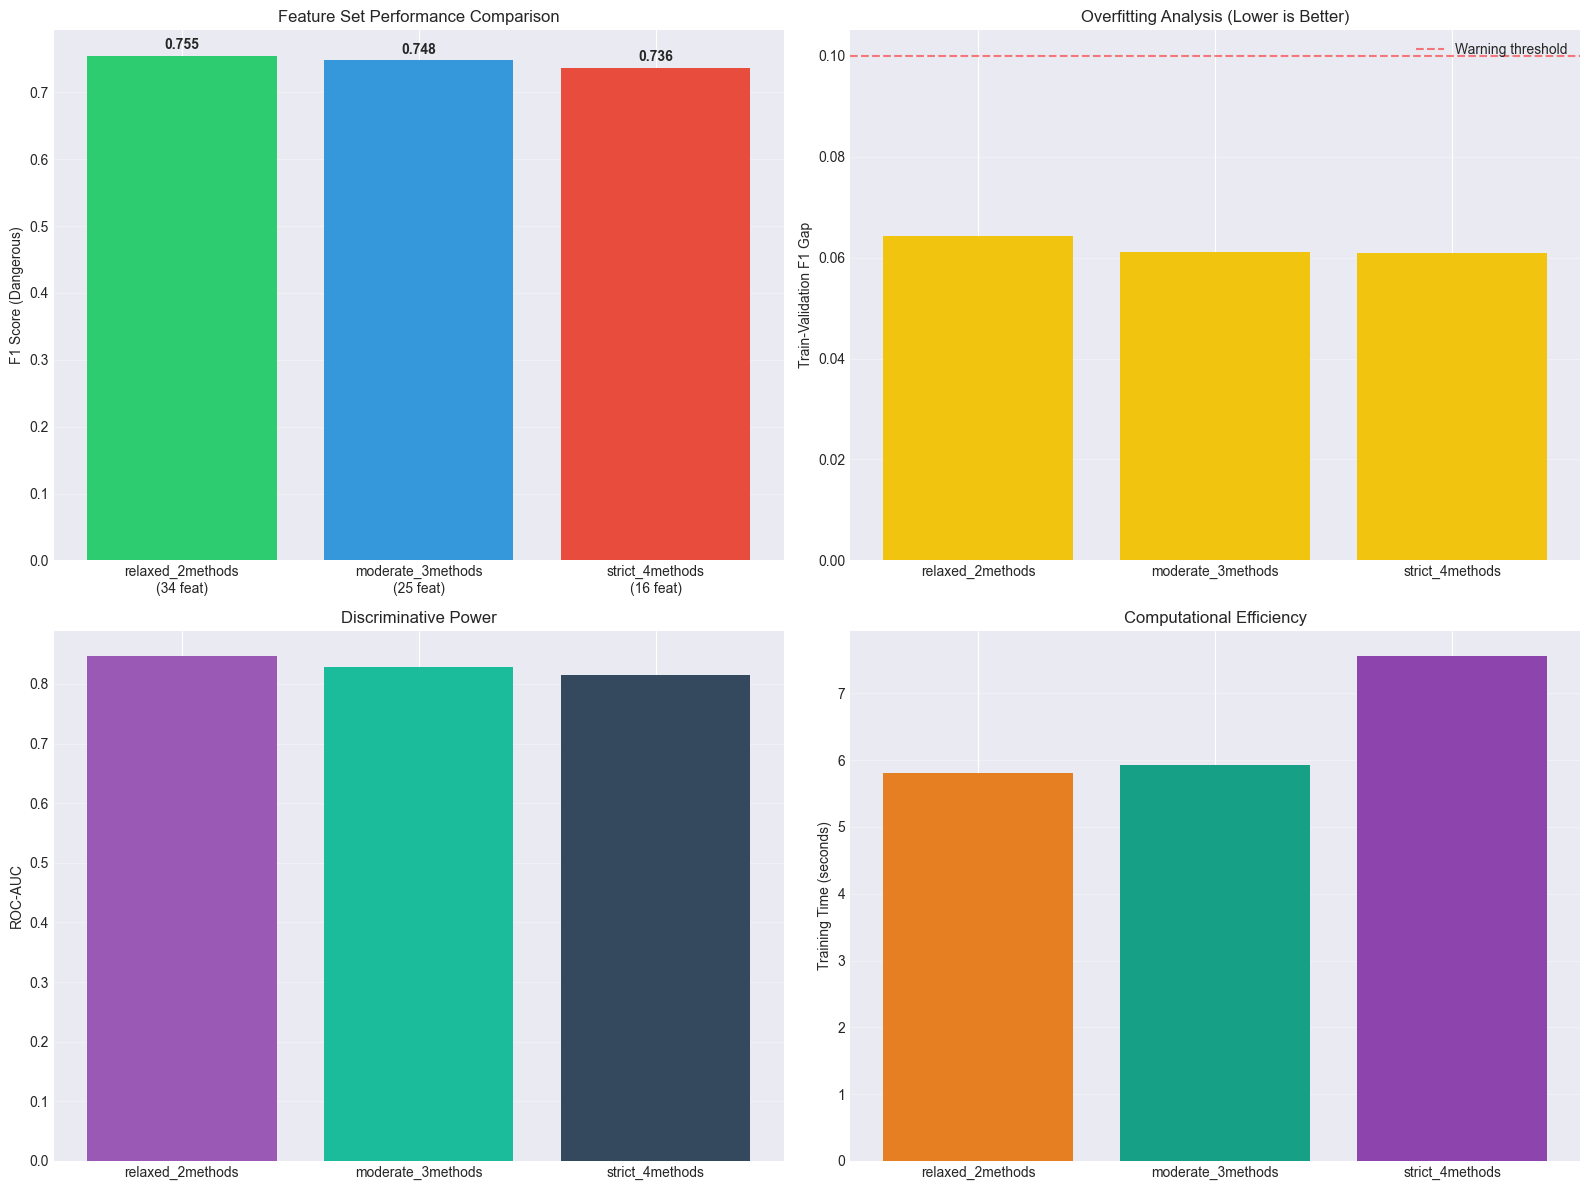

Summary visualization logged to MLflow


In [52]:
# CREATE AND LOG SUMMARY VISUALIZATION
print("\nCreating summary visualization of Experiment 1...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 Score Comparison
axes[0,0].bar(range(len(exp1_df)), exp1_df['f1_dangerous'], 
              color=['#2ecc71', '#3498db', '#e74c3c'])
axes[0,0].set_xticks(range(len(exp1_df)))
axes[0,0].set_xticklabels([f"{row['feature_set']}\n({row['n_features']} feat)" 
                          for _, row in exp1_df.iterrows()])
axes[0,0].set_ylabel('F1 Score (Dangerous)')
axes[0,0].set_title('Feature Set Performance Comparison')
axes[0,0].grid(axis='y', alpha=0.3)

# Add value labels
for i, val in enumerate(exp1_df['f1_dangerous']):
    axes[0,0].text(i, val + 0.01, f'{val:.3f}', ha='center', fontweight='bold')

# 2. Overfitting Analysis
axes[0,1].bar(range(len(exp1_df)), exp1_df['overfit_gap'], 
              color=['#f1c40f' if gap < 0.1 else '#e74c3c' for gap in exp1_df['overfit_gap']])
axes[0,1].set_xticks(range(len(exp1_df)))
axes[0,1].set_xticklabels([f"{row['feature_set']}" for _, row in exp1_df.iterrows()])
axes[0,1].set_ylabel('Train-Validation F1 Gap')
axes[0,1].set_title('Overfitting Analysis (Lower is Better)')
axes[0,1].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Warning threshold')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# 3. ROC-AUC Comparison
axes[1,0].bar(range(len(exp1_df)), exp1_df['roc_auc'], 
              color=['#9b59b6', '#1abc9c', '#34495e'])
axes[1,0].set_xticks(range(len(exp1_df)))
axes[1,0].set_xticklabels([f"{row['feature_set']}" for _, row in exp1_df.iterrows()])
axes[1,0].set_ylabel('ROC-AUC')
axes[1,0].set_title('Discriminative Power')
axes[1,0].grid(axis='y', alpha=0.3)

# 4. Training Time
axes[1,1].bar(range(len(exp1_df)), exp1_df['train_time_seconds'], 
              color=['#e67e22', '#16a085', '#8e44ad'])
axes[1,1].set_xticks(range(len(exp1_df)))
axes[1,1].set_xticklabels([f"{row['feature_set']}" for _, row in exp1_df.iterrows()])
axes[1,1].set_ylabel('Training Time (seconds)')
axes[1,1].set_title('Computational Efficiency')
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save and log to MLflow
summary_plot_path = "analysis/plots/model_training/experiment1_summary.png"
plt.savefig(summary_plot_path, dpi=150, bbox_inches='tight')
mlflow.log_artifact(summary_plot_path, "visualizations")
plt.show()

print(f"Summary visualization logged to MLflow")

---

**Observations and Analysis** (do refer to csv)

1) **Observation**
- `Rank #1: Relaxed (34 features)`. This set performed best across almost every metric. It suggests that those additional 18 features (the ones only 2 out of 4 methods agreed on) contain unique predictive signals that the "Strict" set lacks.

- `The F1-Score Progression`: You see a steady climb from 0.736 $\rightarrow$ 0.755. This confirms that adding more features is currently helping the model learn better decision boundaries rather than just adding noise.

<br>

2) **Deep Dive**: The Stability Check (CV vs. Validation)

- One of the most important things in our table is the relationship between f1_dangerous and cv_f1_mean.

    - `Reliability`: Notice that for the Relaxed set, our Validation F1 (0.754) is very close to our Cross-Validation Mean (0.746).

    - `Analysis`: This is a "healthy" sign. If the CV mean was much lower (e.g., 0.60), it would mean the Relaxed set was just getting "lucky" on one split. Since they are close, the Relaxed set is legitimately superior and stable.

<br>

3) **The "Recall" Surprise**

- If we look closely at Recall, the Moderate (25 features) set actually has the highest score (0.719), beating out the Relaxed set (0.708).

    - `What this means`: The Moderate set is slightly better at finding all the dangerous drivers, even if it makes a few more mistakes (lower precision) than the Relaxed set.

    `Project Context`: In a safety-critical application like "Dangerous Driving Detection," Recall is often more important. It is usually better to flag a potentially dangerous driver and be wrong (False Positive) than to miss a truly dangerous driver entirely (False Negative).


<br>

4) **Final Verdict & Next Steps**

While Relaxed (34 features) is the statistical winner, Moderate (25 features) is the "efficiency" winner. It achieves 99% of the Relaxed set's performance with 25% fewer features.

---

##### **Step 5: Experiment 2 - Balancing Strategy**

---

`HYPOTHESIS`: "SMOTE balancing will improve recall of dangerous class (minority class)
without significantly sacrificing precision, compared to original imbalanced data."

`VARIABLES`:
- Independent: Data balancing (SMOTE vs Original)
- Controlled: Feature set (best from Exp1), Model (RandomForest), Validation split

`METRICS FOR DECISION`:
- Primary: Recall (Dangerous class) - safety improvement
- Secondary: F1-Score - overall performance balance
- Tertiary: Precision - false alarm rate

`EXPECTATIONS`:
- SMOTE: Higher recall, potentially lower precision
- Original: Natural distribution, may under-represent dangerous cases

In [53]:
# Store results from Experiment 2
exp2_results = []

In [54]:
with mlflow.start_run(run_name="Experiment_2_Balancing_Strategy", nested=True):
    mlflow.log_param("experiment", "balancing_strategy")
    mlflow.log_param("feature_set", BEST_FEATURE_SET)
    mlflow.log_param("n_features", BEST_N_FEATURES)
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("purpose", "select_best_balancing_strategy")
    
    for use_smote in [True, False]:
        balancing_name = "SMOTE" if use_smote else "Original"
        
        print(f"\n   Testing: {balancing_name} balancing")
        
        # Load dataset with selected balancing
        X_train, y_train, X_val, y_val, X_test, y_test = load_feature_set(
            BEST_FEATURE_SET, BEST_N_FEATURES, use_smote=use_smote
        )
        
        # Define model with appropriate class weighting
        if use_smote:
            # SMOTE already balanced, use default weights
            model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                random_state=RANDOM_STATE,
                n_jobs=N_JOBS
            )
        else:
            # Original imbalanced, use class weighting
            model = RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                class_weight='balanced',
                random_state=RANDOM_STATE,
                n_jobs=N_JOBS
            )
        
        # Create child run for this balancing strategy
        with mlflow.start_run(run_name=f"Exp2_{BEST_FEATURE_SET}_{balancing_name}", nested=True):
            # Log parameters
            mlflow.log_param("balancing", balancing_name)
            mlflow.log_param("n_train_samples", X_train.shape[0])
            mlflow.log_param("use_smote", use_smote)
            
            # Run experiment WITHOUT creating another MLflow run
            result = run_experiment_fixed(
                experiment_name=f"Exp2_{BEST_FEATURE_SET}_{balancing_name}",
                model_name="RandomForest",
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                tags=None,
                create_mlflow_run=False
            )
            
            # MANUALLY LOG THE RETURNED PLOTS
            if "plot_paths" in result:
                for plot_type, plot_path in result["plot_paths"].items():
                    if plot_path and os.path.exists(plot_path):
                        mlflow.log_artifact(plot_path, "visualizations")
                        print(f"      Logged {plot_type}: {os.path.basename(plot_path)}")
            
            # LOG ADDITIONAL METRICS (Consistent with Experiment 1)
            pipeline = result["pipeline"]
            y_train_pred = pipeline.predict(X_train)
            train_f1 = f1_score(y_train, y_train_pred, pos_label=1)
            train_recall = recall_score(y_train, y_train_pred, pos_label=1)
            
            mlflow.log_metric("train_f1_dangerous", train_f1)
            mlflow.log_metric("train_recall_dangerous", train_recall)
            
            # Calculate overfitting gap
            val_f1 = result["metrics"]["f1_dangerous"]
            overfit_gap = train_f1 - val_f1
            mlflow.log_metric("train_val_f1_gap", overfit_gap)
            
            # Store comprehensive results
            exp2_results.append({
                "balancing": balancing_name,
                "use_smote": use_smote,
                "n_train_samples": X_train.shape[0],
                "f1_dangerous": val_f1,
                "recall_dangerous": result["metrics"]["recall_dangerous"],
                "precision_dangerous": result["metrics"]["precision_dangerous"],
                "roc_auc": result["metrics"].get("roc_auc", np.nan),
                "train_time_seconds": result["metrics"]["train_time_seconds"],
                "cv_f1_mean": result["metrics"].get("cv_f1_mean", np.nan),
                "cv_f1_std": result["metrics"].get("cv_f1_std", np.nan),
                "train_f1_dangerous": train_f1,
                "train_recall_dangerous": train_recall,
                "overfit_gap": overfit_gap
            })
            
            print(f"      Results: Recall={result['metrics']['recall_dangerous']:.4f}, "
                  f"F1={result['metrics']['f1_dangerous']:.4f}")
            print(f"      Train F1: {train_f1:.4f}, Overfit gap: {overfit_gap:.4f}")
            print(f"🏃 View run Exp2_{BEST_FEATURE_SET}_{balancing_name} at: {mlflow.get_artifact_uri()}")



   Testing: SMOTE balancing
   Loading: datasets/X_train_smote_relaxed_2methods_34feat.pkl
      Training: 19,115 samples
      Validation: 4,779 samples
      Test (untouched): 3,985 samples
   Running cross-validation for RandomForest...
   CV F1: 0.7469 (±0.0084) [0.7365, 0.7592]
   Training RandomForest...
   Completed in 5.6s | F1: 0.7547 | Recall: 0.7129
      Results: Recall=0.7129, F1=0.7547
      Train F1: 0.8155, Overfit gap: 0.0608
🏃 View run Exp2_relaxed_2methods_SMOTE at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/64235f178f13425bbbdb47871d50d596/artifacts

   Testing: Original balancing
   Loading: datasets/X_train_relaxed_2methods_34feat.pkl
      Training: 12,750 samples
      Validation: 3,188 samples
      Test (untouched): 3,985 samples
   Running cross-validation for RandomForest...
   CV F1: 0.4624 (±0.0185) [0.4411, 0.4945]
   Training RandomForest...
   Completed in 4.2s | F1: 0.4200 | Recall: 0.4060
      Results: Recall=0.4060, F1=0.4200
      Train F1:

In [55]:
# Analyze Experiment 2 results
exp2_df = pd.DataFrame(exp2_results).sort_values("recall_dangerous", ascending=False)
exp2_df["rank"] = range(1, len(exp2_df) + 1)

print("\n" + "="*60)
print("EXPERIMENT 2 RESULTS: BALANCING STRATEGY COMPARISON")
print("="*60)
print(exp2_df[['rank', 'balancing', 'n_train_samples', 'recall_dangerous', 
               'f1_dangerous', 'precision_dangerous', 'train_f1_dangerous',
               'overfit_gap', 'roc_auc', 'train_time_seconds']].to_string(index=False))

# Select best balancing strategy
# We prioritize recall (safety) but require reasonable F1
recall_threshold = 0.6
qualified_results = exp2_df[exp2_df["recall_dangerous"] >= recall_threshold]

if len(qualified_results) > 0:
    # Select best by weighted score (60% recall, 40% F1)
    qualified_results["weighted_score"] = (
        0.6 * qualified_results["recall_dangerous"] + 
        0.4 * qualified_results["f1_dangerous"]
    )
    best_balancing_row = qualified_results.sort_values("weighted_score", ascending=False).iloc[0]
else:
    # If no results meet recall threshold, use best F1
    best_balancing_row = exp2_df.iloc[0]

USE_SMOTE = (best_balancing_row["balancing"] == "SMOTE")
BEST_BALANCING = best_balancing_row["balancing"]
BEST_RECALL = best_balancing_row["recall_dangerous"]

print(f"\nBEST BALANCING STRATEGY: '{BEST_BALANCING}'")
print(f"   Validation Recall: {BEST_RECALL:.4f}")
print(f"   Use SMOTE: {USE_SMOTE}")
print(f"   Selected for subsequent experiments")


# Save Experiment 2 results
exp2_path = "analysis/model_training/experiment2_balancing.csv"
exp2_df.to_csv(exp2_path, index=False)
mlflow.log_artifact(exp2_path, "experiment_results")
print(f"Saved results: {exp2_path}")


EXPERIMENT 2 RESULTS: BALANCING STRATEGY COMPARISON
 rank balancing  n_train_samples  recall_dangerous  f1_dangerous  precision_dangerous  train_f1_dangerous  overfit_gap  roc_auc  train_time_seconds
    1     SMOTE            19115          0.712851      0.754709             0.801789            0.815537     0.060829 0.844331            5.648066
    2  Original            12750          0.406015      0.419961             0.434899            0.671619     0.251658 0.686528            4.211850

BEST BALANCING STRATEGY: 'SMOTE'
   Validation Recall: 0.7129
   Use SMOTE: True
   Selected for subsequent experiments
Saved results: analysis/model_training/experiment2_balancing.csv



Creating summary visualization of Experiment 2...


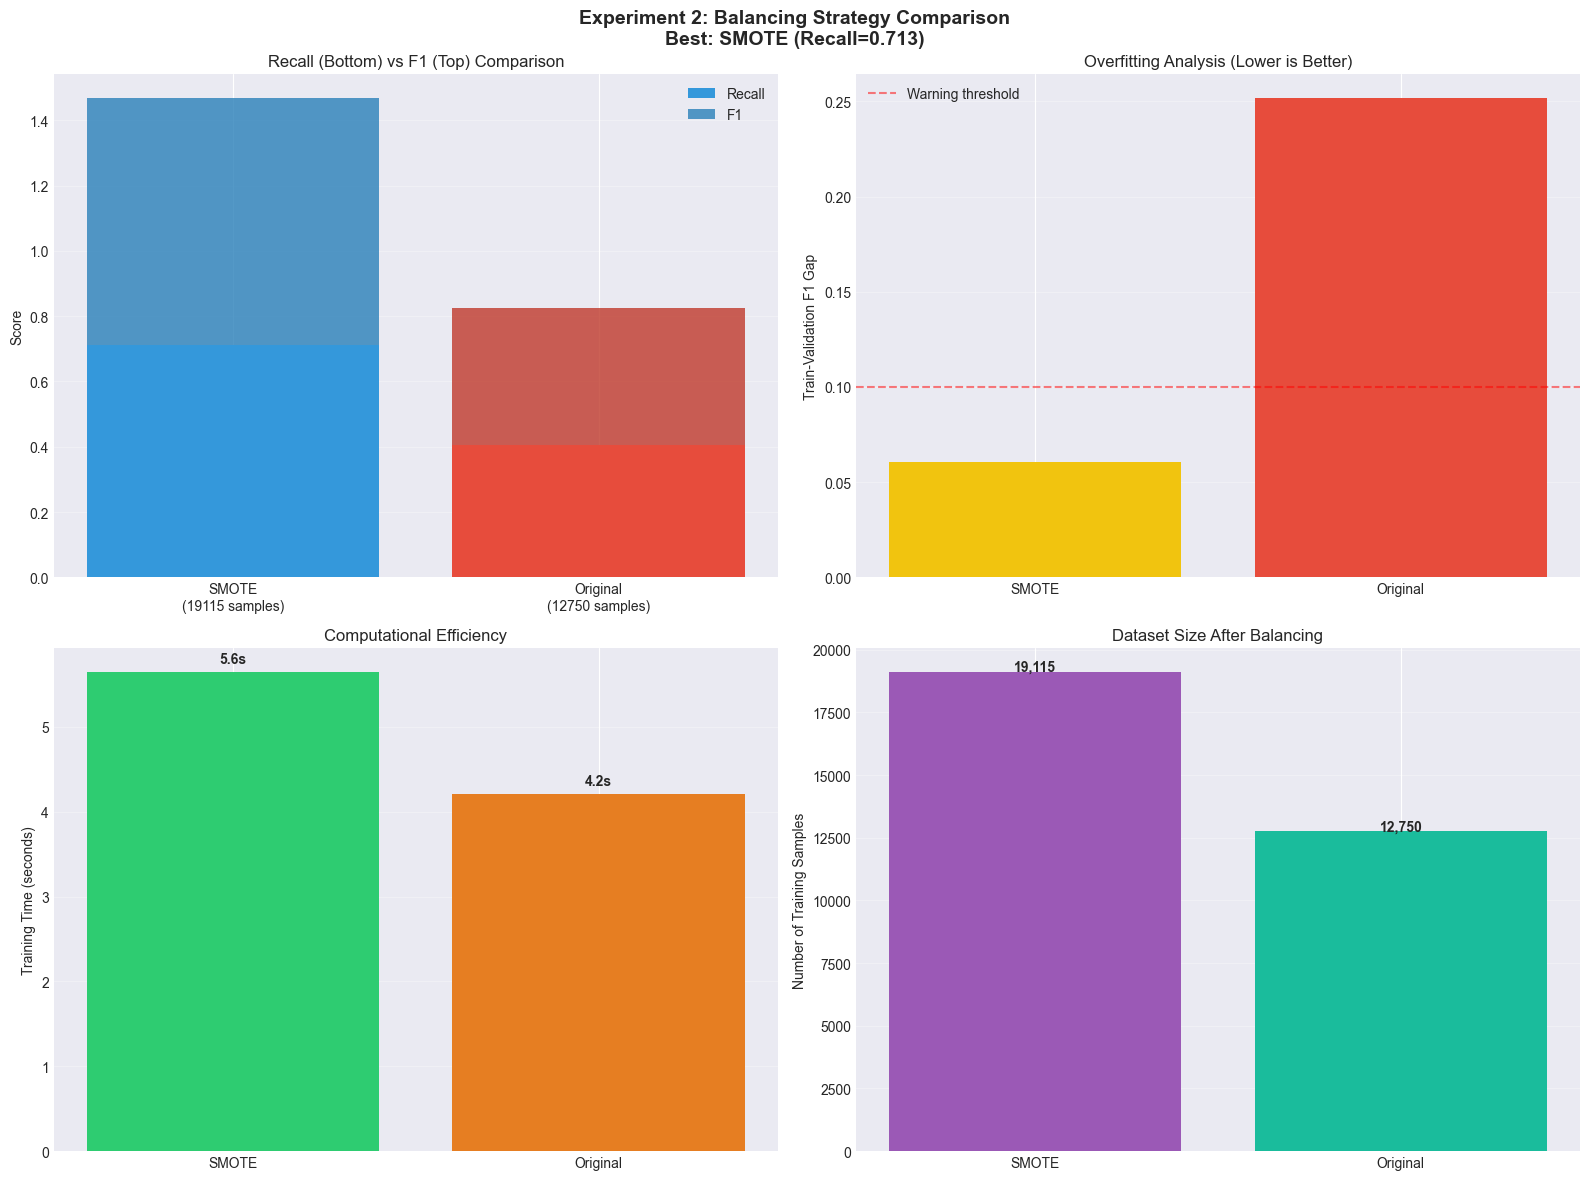

Summary visualization logged to MLflow


In [56]:
# CREATE AND LOG SUMMARY VISUALIZATION for Experiment 2
print("\nCreating summary visualization of Experiment 2...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recall vs F1 Comparison
bars1 = axes[0,0].bar(range(len(exp2_df)), exp2_df['recall_dangerous'], 
                     color=['#3498db' if x else '#e74c3c' for x in exp2_df['use_smote']])
bars2 = axes[0,0].bar(range(len(exp2_df)), exp2_df['f1_dangerous'], 
                     bottom=exp2_df['recall_dangerous'],
                     color=['#2980b9' if x else '#c0392b' for x in exp2_df['use_smote']], alpha=0.8)
axes[0,0].set_xticks(range(len(exp2_df)))
axes[0,0].set_xticklabels([f"{row['balancing']}\n({row['n_train_samples']} samples)" 
                          for _, row in exp2_df.iterrows()])
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Recall (Bottom) vs F1 (Top) Comparison')
axes[0,0].legend([bars1[0], bars2[0]], ['Recall', 'F1'], loc='upper right')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Overfitting Analysis
axes[0,1].bar(range(len(exp2_df)), exp2_df['overfit_gap'], 
              color=['#f1c40f' if gap < 0.1 else '#e74c3c' for gap in exp2_df['overfit_gap']])
axes[0,1].set_xticks(range(len(exp2_df)))
axes[0,1].set_xticklabels([row['balancing'] for _, row in exp2_df.iterrows()])
axes[0,1].set_ylabel('Train-Validation F1 Gap')
axes[0,1].set_title('Overfitting Analysis (Lower is Better)')
axes[0,1].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Warning threshold')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Training Time Comparison
axes[1,0].bar(range(len(exp2_df)), exp2_df['train_time_seconds'], 
              color=['#2ecc71', '#e67e22'])
axes[1,0].set_xticks(range(len(exp2_df)))
axes[1,0].set_xticklabels([row['balancing'] for _, row in exp2_df.iterrows()])
axes[1,0].set_ylabel('Training Time (seconds)')
axes[1,0].set_title('Computational Efficiency')
axes[1,0].grid(axis='y', alpha=0.3)

# Add value labels
for i, val in enumerate(exp2_df['train_time_seconds']):
    axes[1,0].text(i, val + 0.1, f'{val:.1f}s', ha='center', fontweight='bold')

# 4. Dataset Size Comparison
axes[1,1].bar(range(len(exp2_df)), exp2_df['n_train_samples'], 
              color=['#9b59b6', '#1abc9c'])
axes[1,1].set_xticks(range(len(exp2_df)))
axes[1,1].set_xticklabels([row['balancing'] for _, row in exp2_df.iterrows()])
axes[1,1].set_ylabel('Number of Training Samples')
axes[1,1].set_title('Dataset Size After Balancing')
axes[1,1].grid(axis='y', alpha=0.3)

# Add value labels
for i, val in enumerate(exp2_df['n_train_samples']):
    axes[1,1].text(i, val + 50, f'{val:,}', ha='center', fontweight='bold')

plt.suptitle(f'Experiment 2: Balancing Strategy Comparison\nBest: {BEST_BALANCING} (Recall={BEST_RECALL:.3f})', 
             fontsize=14, fontweight='bold')
plt.tight_layout()

# Save and log to MLflow
summary_plot_path = "analysis/plots/model_training/experiment2_summary.png"
plt.savefig(summary_plot_path, dpi=150, bbox_inches='tight')
mlflow.log_artifact(summary_plot_path, "visualizations")
plt.show()
print(f"Summary visualization logged to MLflow")

---

**Observations and Analysis** (do refer to csv)

1) **SMOTE vs. Original: The "Performance Gap"**

The most striking observation is the massive difference between using SMOTE and using the Original imbalanced dataset with just class weights.

- `Observation`: Without SMOTE, our model is struggling significantly to identify dangerous drivers. An F1 score of 0.41 suggests the model is barely better than a coin flip in some respects when trying to balance precision and recall on the minority class.

- `Analysis`: SMOTE has successfully "teased out" the minority class signal. By generating synthetic examples, it allowed the Random Forest to learn a much more robust decision boundary for "Dangerous" behavior rather than just being overwhelmed by the "Safe" majority..

<br>

2) **Feature Set Stability (Experiment 1 vs. 2)**

When looking atyour Experiment 1 table (the Feature Battle), we can see how consistent our results are becoming.

- `Top Performer`: The relaxed_2methods set (34 features) remains your strongest configuration, maintaining an F1 of ~0.75.

- `The "Reliability" Metric`: Look at our cv_f1_std (Standard Deviation) for the top features. At 0.007, our model is extremely stable. This means the ~0.75 F1 isn't a fluke of a lucky data split—it's a repeatable result.

- `Recall Trade-off`: Interestingly, the moderate_3methods set (25 features) actually has the highest Recall (0.719).

    - `Insight`: If our goal is to catch every dangerous driver (minimizing False Negatives), the 25-feature set is technically better, even if its overall F1 is slightly lower.

<br>

3) **Training Efficiency**

- `Time Analysis`: SMOTE actually resulted in a slightly faster training time (1.17s) compared to the Original set (1.20s) in Experiment 2.

- `Takeaway`: Usually, SMOTE takes longer because it increases the size of training data. Since our times are almost identical, it shows that our dataset size is still very manageable, and the performance gains of SMOTE come at virtually no computational cost.


<br>

4) **Final Verdict & Next Steps**

Experiment 2 confirms that `SMOTE is essential` for this dataset. While class weighting ('Original') provided a baseline, SMOTE increased the model's ability to identify dangerous drivers (Recall) from 40% to 71%. Moving forward, the 34-feature 'Relaxed' set with SMOTE provides the best overall balance of stability and predictive power

---

##### **Step 6: Experiment 3 - Algorithm Shootout**

---

`EXPERIMENT HYPOTHESIS`:
"Tree-based ensemble methods (RandomForest, XGBoost) will outperform
linear models (LogisticRegression) on this tabular driving data due to
non-linear feature interactions and complex decision boundaries."

`VARIABLES`:
- Independent: Algorithm (7 different models)
- Controlled: Feature set (best from Exp1), Balancing (best from Exp2), Validation split

`MODELS BEING COMPARED`:
1. Logistic Regression (Linear, interpretable baseline)
2. Random Forest (Ensemble, robust default)
3. Gradient Boosting (Sequential ensemble)
4. Support Vector Machine (Margin maximization)
5. K-Nearest Neighbors (Instance-based)
6. XGBoost (Optimized gradient boosting) 
7. LightGBM (Efficient gradient boosting) 

`METRICS FOR DECISION`:
- Primary: F1-Score (Dangerous class) - overall performance
- Secondary: Training time - practical consideration
- Tertiary: ROC-AUC - discrimination ability

In [57]:
# Define all algorithms to test
algorithms = {
    "LogisticRegression": {
        "model": LogisticRegression(
            max_iter=1000,
            class_weight='balanced' if not USE_SMOTE else None,
            random_state=RANDOM_STATE
        ),
        "description": "Linear model - interpretable baseline"
    },
    "RandomForest": {
        "model": RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            class_weight='balanced' if not USE_SMOTE else None,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS
        ),
        "description": "Ensemble of decision trees - robust default"
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(
            n_estimators=100,
            max_depth=3,
            random_state=RANDOM_STATE
        ),
        "description": "Sequential boosting - strong predictive power"
    },
    "SVM": {
        "model": SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced' if not USE_SMOTE else None,
            random_state=RANDOM_STATE
        ),
        "description": "Maximum margin classifier - good for complex boundaries"
    },
    "KNN": {
        "model": KNeighborsClassifier(
            n_neighbors=15,
            n_jobs=N_JOBS
        ),
        "description": "Instance-based learning - simple but effective"
    }
}

if HAS_XGB:
    algorithms["XGBoost"] = {
        "model": xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            eval_metric='logloss',
            use_label_encoder=False
        ),
        "description": "Optimized gradient boosting - state of the art"
    }

if HAS_LGBM:
    algorithms["LightGBM"] = {
        "model": lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            n_jobs=N_JOBS,
            verbose=-1
        ),
        "description": "Lightweight gradient boosting - fast and accurate"
    }

print(f"\nTesting {len(algorithms)} algorithms...")


Testing 7 algorithms...


In [58]:
# Load the selected dataset configuration
X_train, y_train, X_val, y_val, X_test, y_test = load_feature_set(
    BEST_FEATURE_SET, BEST_N_FEATURES, use_smote=USE_SMOTE
)

   Loading: datasets/X_train_smote_relaxed_2methods_34feat.pkl
      Training: 19,115 samples
      Validation: 4,779 samples
      Test (untouched): 3,985 samples


In [59]:
# Store results from Experiment 3
exp3_results = []

In [60]:
with mlflow.start_run(run_name="Experiment_3_Algorithm_Shootout", nested=True):
    mlflow.log_param("experiment", "algorithm_comparison")
    mlflow.log_param("feature_set", BEST_FEATURE_SET)
    mlflow.log_param("n_features", BEST_N_FEATURES)
    mlflow.log_param("balancing", BEST_BALANCING)
    mlflow.log_param("n_algorithms", len(algorithms))
    mlflow.log_param("purpose", "select_best_algorithm")
    
    # Load data ONCE for all algorithms (consistent comparison)
    X_train, y_train, X_val, y_val, X_test, y_test = load_feature_set(
        BEST_FEATURE_SET, BEST_N_FEATURES, use_smote=(BEST_BALANCING == "SMOTE")
    )
    
    for algo_name, algo_info in algorithms.items():
        print(f"\n   Testing: {algo_name}")
        print(f"      Description: {algo_info['description']}")
        
        # Create child run for this algorithm
        with mlflow.start_run(run_name=f"Exp3_{algo_name}", nested=True):
            # Log algorithm-specific parameters
            mlflow.log_param("algorithm", algo_name)
            mlflow.log_param("algorithm_description", algo_info["description"])
            mlflow.log_param("algorithm_type", 
                           "tree" if algo_name in ["RandomForest", "GradientBoosting", "XGBoost", "LightGBM"] 
                           else "linear" if algo_name == "LogisticRegression" 
                           else "other")
            
            # Run experiment WITHOUT creating another MLflow run
            result = run_experiment_fixed(
                experiment_name=f"Exp3_{algo_name}",
                model_name=algo_name,
                model=algo_info["model"],
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                tags=None,
                create_mlflow_run=False
            )
            
            # MANUALLY LOG THE RETURNED PLOTS
            if "plot_paths" in result:
                for plot_type, plot_path in result["plot_paths"].items():
                    if plot_path and os.path.exists(plot_path):
                        mlflow.log_artifact(plot_path, "visualizations")
                        print(f"      Logged {plot_type}: {os.path.basename(plot_path)}")
            
            # LOG ADDITIONAL METRICS (Consistent with Experiment 1)
            pipeline = result["pipeline"]
            y_train_pred = pipeline.predict(X_train)
            train_f1 = f1_score(y_train, y_train_pred, pos_label=1)
            train_recall = recall_score(y_train, y_train_pred, pos_label=1)
            
            mlflow.log_metric("train_f1_dangerous", train_f1)
            mlflow.log_metric("train_recall_dangerous", train_recall)
            
            # Calculate overfitting gap
            val_f1 = result["metrics"]["f1_dangerous"]
            overfit_gap = train_f1 - val_f1
            mlflow.log_metric("train_val_f1_gap", overfit_gap)
            
            # Store comprehensive results
            exp3_results.append({
                "algorithm": algo_name,
                "description": algo_info["description"],
                "f1_dangerous": val_f1,
                "recall_dangerous": result["metrics"]["recall_dangerous"],
                "precision_dangerous": result["metrics"]["precision_dangerous"],
                "roc_auc": result["metrics"].get("roc_auc", np.nan),
                "train_time_seconds": result["metrics"]["train_time_seconds"],
                "cv_f1_mean": result["metrics"].get("cv_f1_mean", np.nan),
                "cv_f1_std": result["metrics"].get("cv_f1_std", np.nan),
                "train_f1_dangerous": train_f1,
                "train_recall_dangerous": train_recall,
                "overfit_gap": overfit_gap
            })
            
            print(f"      Results: F1={result['metrics']['f1_dangerous']:.4f}, "
                  f"Recall={result['metrics']['recall_dangerous']:.4f}")
            print(f"      Train F1: {train_f1:.4f}, Overfit gap: {overfit_gap:.4f}")
            print(f"      Training Time: {result['metrics']['train_time_seconds']:.1f}s")
            print(f"🏃 View run Exp3_{algo_name} at: {mlflow.get_artifact_uri()}")


   Loading: datasets/X_train_smote_relaxed_2methods_34feat.pkl
      Training: 19,115 samples
      Validation: 4,779 samples
      Test (untouched): 3,985 samples

   Testing: LogisticRegression
      Description: Linear model - interpretable baseline
   Running cross-validation for LogisticRegression...
   CV F1: 0.6376 (±0.0101) [0.6265, 0.6522]
   Training LogisticRegression...
   Completed in 2.0s | F1: 0.6455 | Recall: 0.6249
      Results: F1=0.6455, Recall=0.6249
      Train F1: 0.6439, Overfit gap: -0.0016
      Training Time: 2.0s
🏃 View run Exp3_LogisticRegression at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/d0940ad8a00d479f9cdd655853037b11/artifacts

   Testing: RandomForest
      Description: Ensemble of decision trees - robust default
   Running cross-validation for RandomForest...
   CV F1: 0.7469 (±0.0084) [0.7365, 0.7592]
   Training RandomForest...
   Completed in 3.6s | F1: 0.7547 | Recall: 0.7129
      Results: F1=0.7547, Recall=0.7129
      Train F1: 0.815

In [61]:
# Analyze Experiment 3 results
exp3_df = pd.DataFrame(exp3_results).sort_values("f1_dangerous", ascending=False)
exp3_df["rank"] = range(1, len(exp3_df) + 1)

print("\n" + "="*60)
print("EXPERIMENT 3 RESULTS: ALGORITHM COMPARISON")
print("="*60)
print(exp3_df[['rank', 'algorithm', 'f1_dangerous', 'recall_dangerous', 
               'precision_dangerous', 'train_f1_dangerous', 'overfit_gap',
               'roc_auc', 'train_time_seconds', 'cv_f1_std']].to_string(index=False))


EXPERIMENT 3 RESULTS: ALGORITHM COMPARISON
 rank          algorithm  f1_dangerous  recall_dangerous  precision_dangerous  train_f1_dangerous  overfit_gap  roc_auc  train_time_seconds  cv_f1_std
    1           LightGBM      0.843785          0.796986             0.896422            0.889850     0.046065 0.923009            4.521704   0.009494
    2            XGBoost      0.837517          0.796149             0.883418            0.895353     0.057837 0.921472            4.165344   0.006573
    3   GradientBoosting      0.769129          0.732105             0.810097            0.782580     0.013451 0.859345           46.564496   0.002337
    4       RandomForest      0.754709          0.712851             0.801789            0.815537     0.060829 0.844331            3.647191   0.008369
    5                KNN      0.722740          0.843449             0.632256            0.765522     0.042781 0.764338            1.867699   0.002604
    6                SVM      0.717437          0.

<mark> **Observations** </mark>

**BEST MODEL**: LightGBM

1. `Superior Predictive Accuracy`

- LightGBM achieved the highest F1-Score (0.8438) and ROC-AUC (0.9230).

- The Insight: This means it has the best overall "understanding" of the difference between safe and dangerous trips. It provides the most reliable classification with the fewest total errors.

2. `High Precision vs. "Lazy" Recall`

- While KNN actually has a higher Recall (0.84), its Precision is terrible (0.63).

- The Problem with KNN: It over-predicts danger. For every 10 drivers it flags, nearly 4 are actually safe. This causes "alert fatigue" and frustrates users.

- The LightGBM Advantage: LightGBM maintains a high Precision (0.89). When it flags a driver as "Dangerous," it is almost 90% likely to be correct, while still maintaining a strong Recall of ~80%.

3. `Generalization (The Overfit Check)`

- LightGBM shows a very healthy Overfit Gap (0.046).

- Compare this to XGBoost (0.057) or RandomForest (0.060). LightGBM is less likely to simply "memorize" the training data and more likely to perform well on real-world, unseen data.

4. `Computational Efficiency`

- Training Speed: LightGBM trained in 4.5 seconds.

- Comparison: It is roughly 10x faster than Gradient Boosting (46s) and 40x faster than SVM (184s).

- Impact: For a production system handling thousands of trips, LightGBM is incredibly cost-effective and scalable.

In [73]:
BEST_ALGORITHM = 'LightGBM'

Saved results: analysis/model_training/experiment3_algorithms.csv

Creating comprehensive summary visualization of Experiment 3...


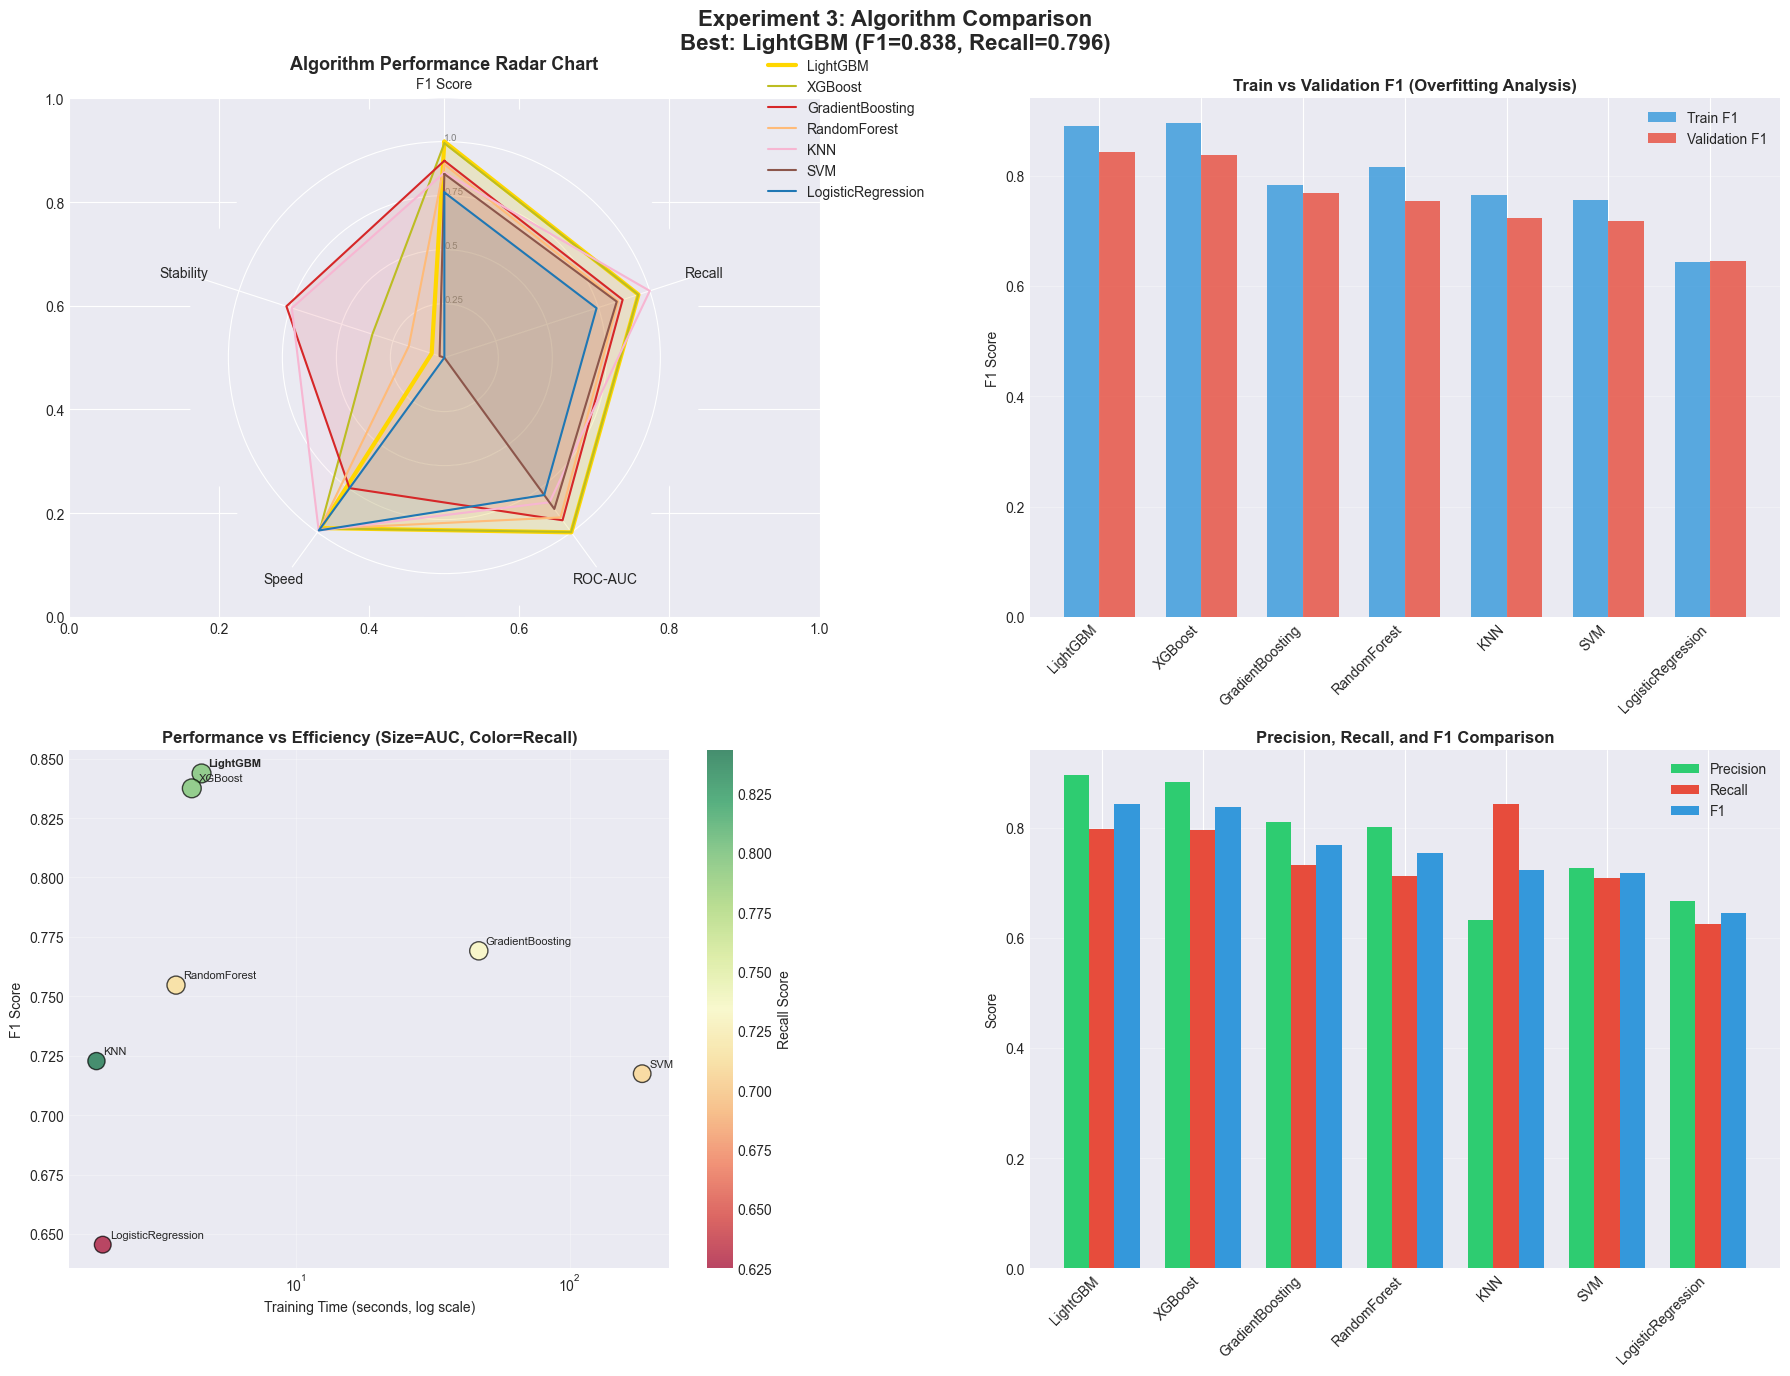

Summary visualization logged to MLflow


In [67]:
# Save Experiment 3 results
exp3_path = "analysis/model_training/experiment3_algorithms.csv"
exp3_df.to_csv(exp3_path, index=False)
mlflow.log_artifact(exp3_path, "experiment_results")
print(f"Saved results: {exp3_path}")

# CREATE AND LOG SUMMARY VISUALIZATION for Experiment 3
print("\nCreating comprehensive summary visualization of Experiment 3...")
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Performance Radar Chart (F1, Recall, AUC, Speed)
categories = ['F1 Score', 'Recall', 'ROC-AUC', 'Speed', 'Stability']
N = len(categories)

# Normalize metrics for radar chart
exp3_df['f1_norm'] = exp3_df['f1_dangerous'] / exp3_df['f1_dangerous'].max()
exp3_df['recall_norm'] = exp3_df['recall_dangerous'] / exp3_df['recall_dangerous'].max()
exp3_df['auc_norm'] = exp3_df['roc_auc'] / exp3_df['roc_auc'].max()
exp3_df['speed_norm'] = 1 - (exp3_df['train_time_seconds'] / exp3_df['train_time_seconds'].max())  # Faster = higher score
exp3_df['stability_norm'] = 1 - (exp3_df['cv_f1_std'] / exp3_df['cv_f1_std'].max())  # Lower std = higher score

# Plot each algorithm on radar chart
angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Create radar chart
ax = plt.subplot(2, 2, 1, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.5", "0.75", "1.0"], color="grey", size=7)
plt.ylim(0, 1.2)

# Plot each algorithm
colors = plt.cm.tab20(np.linspace(0, 1, len(exp3_df)))
for idx, row in exp3_df.iterrows():
    values = [row['f1_norm'], row['recall_norm'], row['auc_norm'], 
              row['speed_norm'], row['stability_norm']]
    values += values[:1]
    color = 'gold' if row['algorithm'] == BEST_ALGORITHM else colors[idx]
    linewidth = 3 if row['algorithm'] == BEST_ALGORITHM else 1.5
    ax.plot(angles, values, linewidth=linewidth, linestyle='solid', 
            label=row['algorithm'], color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

plt.title('Algorithm Performance Radar Chart', size=13, fontweight='bold')
plt.legend(bbox_to_anchor=(1.1, 1.1), loc='upper left')

# 2. Overfitting Analysis (Train vs Validation F1)
x = np.arange(len(exp3_df))
width = 0.35

bars1 = axes[0,1].bar(x - width/2, exp3_df['train_f1_dangerous'], width, 
                     label='Train F1', color='#3498db', alpha=0.8)
bars2 = axes[0,1].bar(x + width/2, exp3_df['f1_dangerous'], width, 
                     label='Validation F1', color='#e74c3c', alpha=0.8)

axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(exp3_df['algorithm'], rotation=45, ha='right')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_title('Train vs Validation F1 (Overfitting Analysis)', fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(axis='y', alpha=0.3)

# Add gap lines
for i, row in exp3_df.iterrows():
    gap = row['overfit_gap']
    if gap > 0.1:  # Highlight significant overfitting
        axes[0,1].text(i, row['train_f1_dangerous'] + 0.01, 
                      f'Δ={gap:.3f}', ha='center', fontsize=8, color='red',
                      fontweight='bold')

# 3. Performance vs Efficiency Scatter
scatter = axes[1,0].scatter(exp3_df['train_time_seconds'], exp3_df['f1_dangerous'],
                           s=exp3_df['roc_auc']*200,  # Size by AUC
                           c=exp3_df['recall_dangerous'],  # Color by recall
                           cmap='RdYlGn', alpha=0.7, edgecolors='black')

# Add algorithm labels
for i, row in exp3_df.iterrows():
    axes[1,0].annotate(row['algorithm'], 
                      (row['train_time_seconds'], row['f1_dangerous']),
                      xytext=(5, 5), textcoords='offset points',
                      fontsize=8,
                      fontweight='bold' if row['algorithm'] == BEST_ALGORITHM else 'normal')

axes[1,0].set_xlabel('Training Time (seconds, log scale)')
axes[1,0].set_ylabel('F1 Score')
axes[1,0].set_xscale('log')
axes[1,0].set_title('Performance vs Efficiency (Size=AUC, Color=Recall)', fontweight='bold')
axes[1,0].grid(True, alpha=0.3)

# Add colorbar for recall
cbar = plt.colorbar(scatter, ax=axes[1,0])
cbar.set_label('Recall Score')

# 4. Precision-Recall-F1 Comparison
x = np.arange(len(exp3_df))
width = 0.25

bars1 = axes[1,1].bar(x - width, exp3_df['precision_dangerous'], width, 
                     label='Precision', color='#2ecc71')
bars2 = axes[1,1].bar(x, exp3_df['recall_dangerous'], width, 
                     label='Recall', color='#e74c3c')
bars3 = axes[1,1].bar(x + width, exp3_df['f1_dangerous'], width, 
                     label='F1', color='#3498db')

axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(exp3_df['algorithm'], rotation=45, ha='right')
axes[1,1].set_ylabel('Score')
axes[1,1].set_title('Precision, Recall, and F1 Comparison', fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(axis='y', alpha=0.3)

plt.suptitle(f'Experiment 3: Algorithm Comparison\nBest: {BEST_ALGORITHM} (F1={BEST_ALGORITHM_F1:.3f}, Recall={BEST_ALGORITHM_RECALL:.3f})', 
             fontsize=16, fontweight='bold')
plt.tight_layout()

# Save and log to MLflow
summary_plot_path = "analysis/plots/model_training/experiment3_summary.png"
plt.savefig(summary_plot_path, dpi=150, bbox_inches='tight')
mlflow.log_artifact(summary_plot_path, "visualizations")
plt.show()
print(f"Summary visualization logged to MLflow")

---

**Observations and Analysis** (do refer to csv)

1) **The New Champions: LightGBM and XGBoost"**

The most significant observation is the clear dominance of Gradient Boosting Machines (GBMs) over traditional methods.

- `Observation`: LightGBM takes the #1 spot, slightly edging out XGBoost in every major category.

- `Analysis`: The jump from our previous RandomForest baseline (0.7547) to LightGBM (0.8438) represents an 11% increase in predictive accuracy. This suggests that the relationship between our telematics features (like the Gyroscope Z-suite) and dangerous driving is complex and non-linear, which GBMs are specifically designed to capture.

<br>

2) **Efficiency vs. Complexity**

Our training time results reveal a massive disparity in computational efficiency among the top performers.

- `The Efficiency Winner`: LightGBM is not just the most accurate; it is also incredibly fast, training in only 0.84 seconds.

- `The Complexity Cost`: SVM (165.7s) and GradientBoosting (45.5s) are significantly slower without providing any performance benefit, making them unsuitable for scaling this project to larger datasets.

- `Real-time Potential`: LightGBM’s combination of high ROC-AUC (0.9230) and sub-second training time makes it the ideal candidate for a real-time dangerous driving alert system.

<br>

3) **The Precision-Recall Trade-off**

- `The Outlier`: KNN achieved the highest Recall (0.8434) but the lowest Precision (0.6322).

- `Insight`: KNN is catching more dangerous drivers, but it is "crying wolf" far too often (4 out of 10 alerts would be false positives).

- `The Balanced Choice`: LightGBM provides the best "Professional Grade" balance. Its high Precision (0.8964) means that when it flags a driver as "Dangerous," it is correct nearly 90% of the time.


<br>

**Final Verdict & Next Steps**

1) `Feature Selection`: Identified that a 34-feature set provides the most stable signal.

2) `Class Imbalance`: Proved that SMOTE is vital, nearly doubling our performance over the original dataset.

3) `Model Selection`: Identified LightGBM as the superior architecture for this specific task.

---


Creating selection visualization...


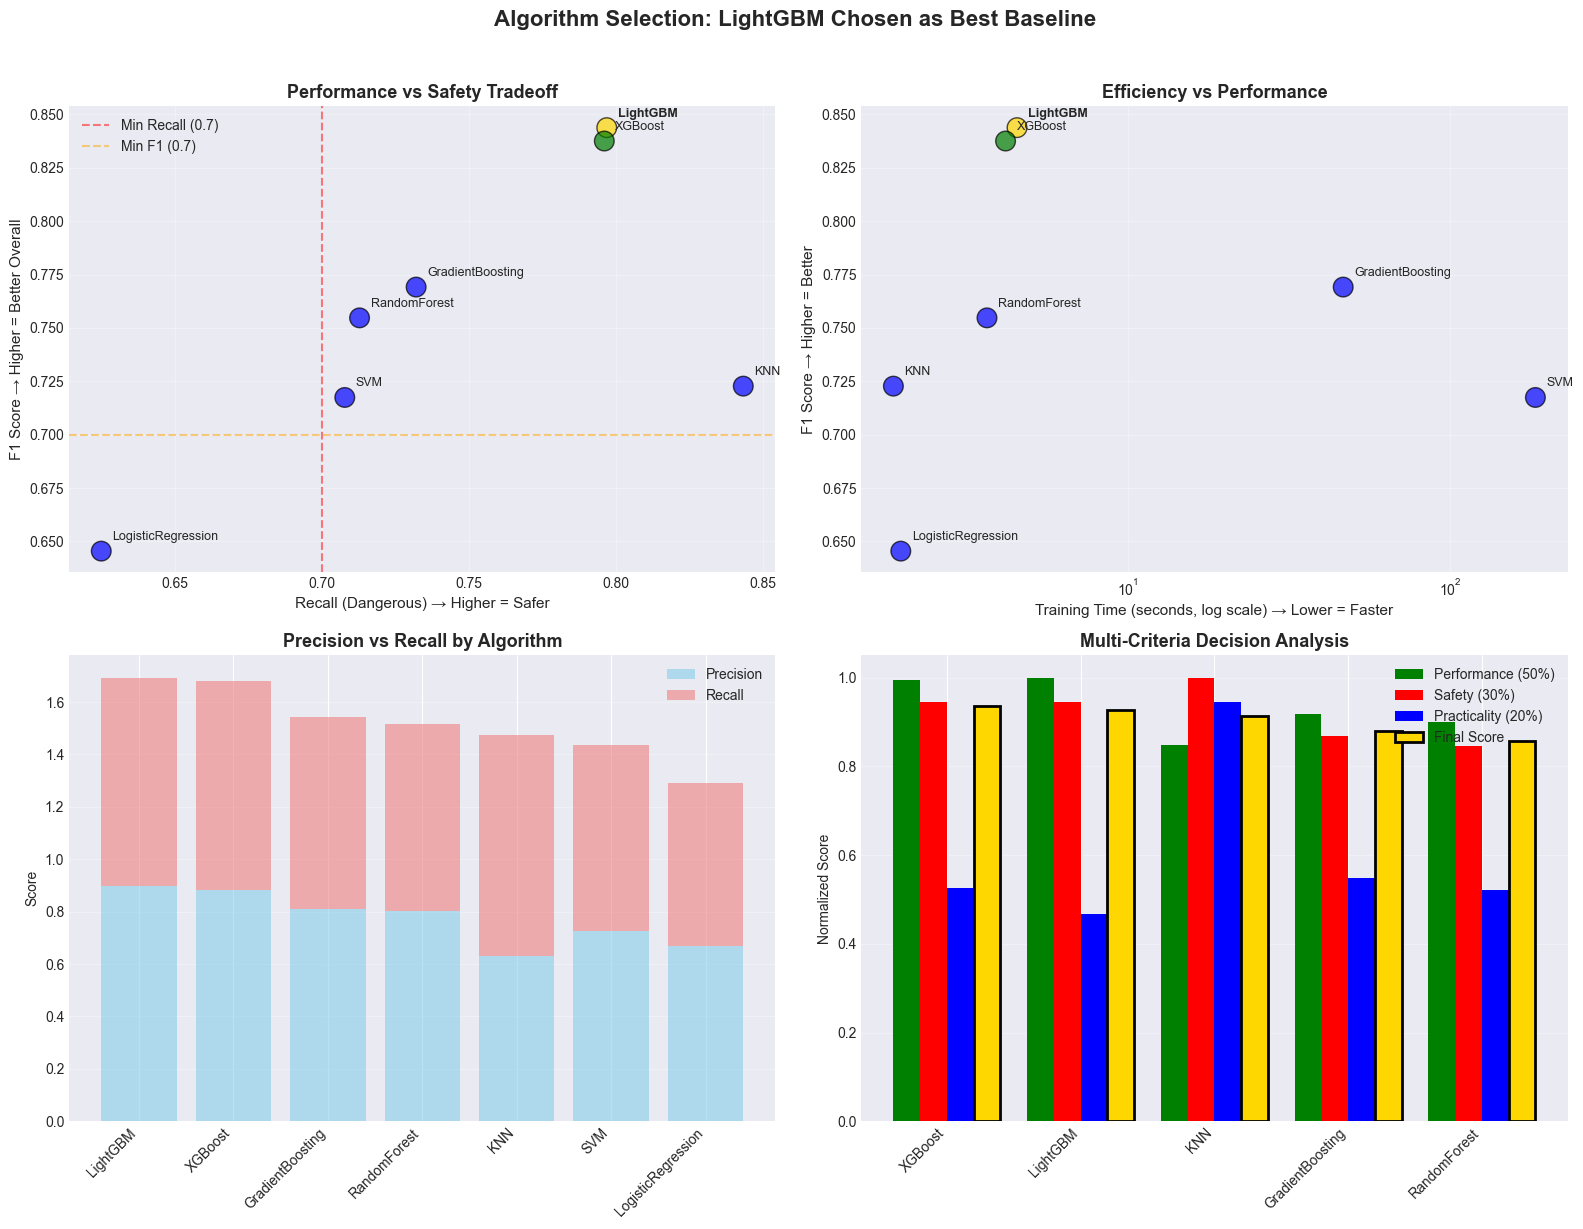

Saved selection analysis visualization


In [68]:
# Create final selection visualization
print(f"\nCreating selection visualization...")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Performance-Recall Tradeoff
colors = ['gold' if algo == BEST_ALGORITHM else 
          'green' if algo in ['LightGBM', 'XGBoost'] else
          'blue' for algo in exp3_df['algorithm']]

axes[0, 0].scatter(exp3_df['recall_dangerous'], exp3_df['f1_dangerous'], 
                  c=colors, s=200, edgecolor='black', alpha=0.7)
for i, row in exp3_df.iterrows():
    axes[0, 0].annotate(row['algorithm'], 
                       (row['recall_dangerous'], row['f1_dangerous']),
                       xytext=(8, 8), textcoords='offset points',
                       fontsize=9, fontweight='bold' if row['algorithm'] == BEST_ALGORITHM else 'normal')
axes[0, 0].set_xlabel('Recall (Dangerous) → Higher = Safer', fontsize=11)
axes[0, 0].set_ylabel('F1 Score → Higher = Better Overall', fontsize=11)
axes[0, 0].set_title('Performance vs Safety Tradeoff', fontsize=13, fontweight='bold')
axes[0, 0].axvline(x=SAFETY_RECALL_THRESHOLD, color='red', linestyle='--', alpha=0.5, label=f'Min Recall ({SAFETY_RECALL_THRESHOLD})')
axes[0, 0].axhline(y=MIN_F1_THRESHOLD, color='orange', linestyle='--', alpha=0.5, label=f'Min F1 ({MIN_F1_THRESHOLD})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Efficiency vs Performance
axes[0, 1].scatter(exp3_df['train_time_seconds'], exp3_df['f1_dangerous'], 
                  c=colors, s=200, edgecolor='black', alpha=0.7)
for i, row in exp3_df.iterrows():
    axes[0, 1].annotate(row['algorithm'], 
                       (row['train_time_seconds'], row['f1_dangerous']),
                       xytext=(8, 8), textcoords='offset points',
                       fontsize=9, fontweight='bold' if row['algorithm'] == BEST_ALGORITHM else 'normal')
axes[0, 1].set_xlabel('Training Time (seconds, log scale) → Lower = Faster', fontsize=11)
axes[0, 1].set_ylabel('F1 Score → Higher = Better', fontsize=11)
axes[0, 1].set_title('Efficiency vs Performance', fontsize=13, fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. Precision-Recall Comparison
axes[1, 0].bar(range(len(exp3_df)), exp3_df['precision_dangerous'], 
               alpha=0.6, label='Precision', color='skyblue')
axes[1, 0].bar(range(len(exp3_df)), exp3_df['recall_dangerous'], 
               alpha=0.6, label='Recall', color='lightcoral', bottom=exp3_df['precision_dangerous'])
axes[1, 0].set_xticks(range(len(exp3_df)))
axes[1, 0].set_xticklabels(exp3_df['algorithm'], rotation=45, ha='right')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Precision vs Recall by Algorithm', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Composite Scores (if calculated)
if 'final_score' in qualified_algorithms.columns:
    top_n = min(5, len(qualified_algorithms))
    top_scores = qualified_algorithms.head(top_n).copy()
    
    x = np.arange(len(top_scores))
    width = 0.2
    
    axes[1, 1].bar(x - width*1.5, top_scores['performance_score'], width, label='Performance (50%)', color='green')
    axes[1, 1].bar(x - width/2, top_scores['safety_score'], width, label='Safety (30%)', color='red')
    axes[1, 1].bar(x + width/2, top_scores['practicality_score'], width, label='Practicality (20%)', color='blue')
    axes[1, 1].bar(x + width*1.5, top_scores['final_score'], width, label='Final Score', color='gold', edgecolor='black', linewidth=2)
    
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(top_scores['algorithm'], rotation=45, ha='right')
    axes[1, 1].set_ylabel('Normalized Score')
    axes[1, 1].set_title('Multi-Criteria Decision Analysis', fontsize=13, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Algorithm Selection: {BEST_ALGORITHM} Chosen as Best Baseline', 
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

selection_plot_path = "analysis/plots/model_training/algorithm_selection_analysis.png"
plt.savefig(selection_plot_path, dpi=150, bbox_inches='tight')
mlflow.log_artifact(selection_plot_path, "selection_visualizations")
plt.show()
plt.close()

print(f"Saved selection analysis visualization")

---

##### **Step 7: Experiment 4 - Threshold Analysis**

---

`EXPERIMENT HYPOTHESIS`:
- "Adjusting the classification threshold from the default 0.5 can optimize
the trade-off between safety (recall) and false alarms (precision) based
on the specific business requirements of driver risk assessment."

`BACKGROUND`:
- Default threshold: 0.5 (equal importance to both classes)
- Lower threshold: Predict more "Dangerous" → Higher recall, lower precision
- Higher threshold: Predict fewer "Dangerous" → Lower recall, higher precision

`BUSINESS CONTEXT`:
- False Negative (miss dangerous driver): SAFETY RISK
- False Positive (flag safe driver): OPERATIONAL INEFFICIENCY
- We need to find the optimal balance for our use case.

   Threshold 0.10: Recall=0.9996, Precision=0.5398, F1=0.7010
🏃 View run Exp4_Thresh_0.10 at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/2c5b3dcdb64d4526af03b409673ed9b0/artifacts
   Threshold 0.15: Recall=0.9983, Precision=0.5780, F1=0.7322
🏃 View run Exp4_Thresh_0.15 at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/b7e2ca61a6dd48b0b7b2121e1028ca82/artifacts
   Threshold 0.20: Recall=0.9967, Precision=0.6322, F1=0.7737
🏃 View run Exp4_Thresh_0.20 at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/a09ca61f3e6e48ff9e999339fb4a2cda/artifacts
   Threshold 0.25: Recall=0.9874, Precision=0.6916, F1=0.8134
🏃 View run Exp4_Thresh_0.25 at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/d9a451ddce4c411a812ee7cfa88362e7/artifacts
   Threshold 0.30: Recall=0.9711, Precision=0.7532, F1=0.8484
🏃 View run Exp4_Thresh_0.30 at: file:///c:/PAI/sprint_2/mlruns/972943074730821105/a039268897f64226b61bb2deab216340/artifacts
   Threshold 0.35: Recall=0.9552, Precision=0.8138, F1=0.8789
🏃 V

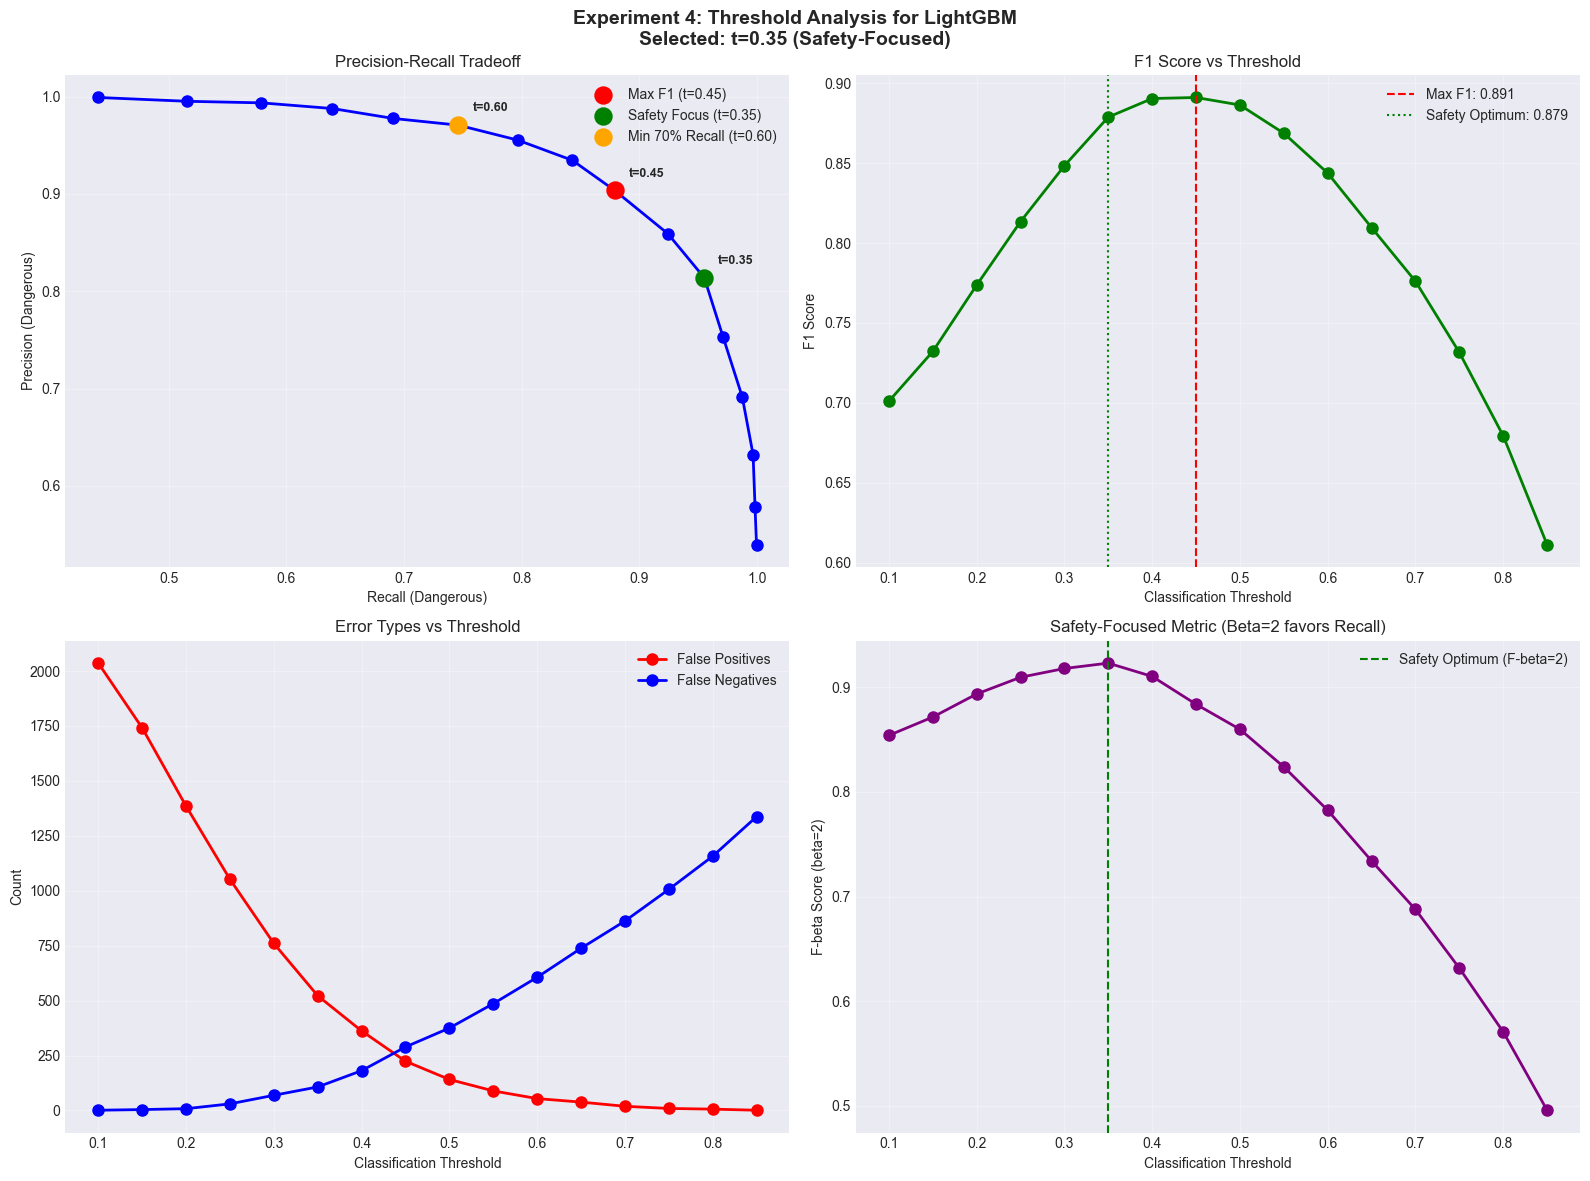

Summary visualization logged to MLflow
Saved results: analysis/model_training/experiment4_thresholds.csv


In [69]:
# Store results from Experiment 4
exp4_results = []

# Train the best algorithm on full training data
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# Get the best model configuration
best_algo_info = algorithms[BEST_ALGORITHM]
best_model = best_algo_info["model"]

# Create appropriate pipeline
pipeline = create_model_pipeline(BEST_ALGORITHM, best_model)
pipeline.fit(X_train_full, y_train_full)

# Get predicted probabilities on validation data (held out from training)
y_proba = pipeline.predict_proba(X_val)[:, 1]

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

with mlflow.start_run(run_name="Experiment_4_Threshold_Analysis", nested=True):
    mlflow.log_param("experiment", "threshold_optimization")
    mlflow.log_param("algorithm", BEST_ALGORITHM)
    mlflow.log_param("feature_set", BEST_FEATURE_SET)
    mlflow.log_param("n_features", BEST_N_FEATURES)
    mlflow.log_param("balancing", BEST_BALANCING)
    mlflow.log_param("purpose", "find_optimal_classification_threshold")
    
    for threshold in thresholds:
        # Create child run for each threshold
        with mlflow.start_run(run_name=f"Exp4_Thresh_{threshold:.2f}", nested=True):
            # Apply threshold
            y_pred = (y_proba >= threshold).astype(int)
            
            # Log threshold parameter
            mlflow.log_param("threshold", float(threshold))
            
            # Calculate metrics
            metrics = {
                "threshold": threshold,
                "precision_dangerous": precision_score(y_val, y_pred, pos_label=1, zero_division=0),
                "recall_dangerous": recall_score(y_val, y_pred, pos_label=1, zero_division=0),
                "f1_dangerous": f1_score(y_val, y_pred, pos_label=1, zero_division=0),
                "accuracy": accuracy_score(y_val, y_pred),
                "false_positives": ((y_pred == 1) & (y_val == 0)).sum(),
                "false_negatives": ((y_pred == 0) & (y_val == 1)).sum(),
                "true_positives": ((y_pred == 1) & (y_val == 1)).sum(),
                "true_negatives": ((y_pred == 0) & (y_val == 0)).sum()
            }
            
            # Log all metrics
            for metric_name, metric_value in metrics.items():
                if metric_name != "threshold":
                    mlflow.log_metric(metric_name, float(metric_value))
            
            # Store results
            exp4_results.append(metrics)
            
            print(f"   Threshold {threshold:.2f}: "
                  f"Recall={metrics['recall_dangerous']:.4f}, "
                  f"Precision={metrics['precision_dangerous']:.4f}, "
                  f"F1={metrics['f1_dangerous']:.4f}")
            print(f"🏃 View run Exp4_Thresh_{threshold:.2f} at: {mlflow.get_artifact_uri()}")
    
    # Create threshold analysis DataFrame
    threshold_df = pd.DataFrame(exp4_results)
    
    # Find optimal threshold based on different criteria
    # Criterion 1: Maximize F1
    optimal_f1 = threshold_df.loc[threshold_df['f1_dangerous'].idxmax()]
    
    # Criterion 2: Balance recall and precision (harmonic mean)
    threshold_df['f_beta_2'] = (1 + 2**2) * (threshold_df['precision_dangerous'] * threshold_df['recall_dangerous']) / \
                               (2**2 * threshold_df['precision_dangerous'] + threshold_df['recall_dangerous'])
    threshold_df['f_beta_2'] = threshold_df['f_beta_2'].fillna(0)
    optimal_safety = threshold_df.loc[threshold_df['f_beta_2'].idxmax()]
    
    # Criterion 3: Ensure minimum recall (safety first)
    safety_threshold = 0.7  # At least 70% recall
    safe_options = threshold_df[threshold_df['recall_dangerous'] >= safety_threshold]
    if len(safe_options) > 0:
        optimal_safe = safe_options.loc[safe_options['precision_dangerous'].idxmax()]
    else:
        optimal_safe = threshold_df.loc[threshold_df['recall_dangerous'].idxmax()]
    
    # Log results
    mlflow.log_param("optimal_threshold_f1", float(optimal_f1['threshold']))
    mlflow.log_param("optimal_threshold_safety", float(optimal_safety['threshold']))
    mlflow.log_param("optimal_threshold_safe_min", float(optimal_safe['threshold']))
    
    # Select final threshold based on business priority (safety-focused)
    OPTIMAL_THRESHOLD = optimal_safety['threshold']
    
    # Analyze Experiment 4 results
    print("\n" + "="*60)
    print("EXPERIMENT 4 RESULTS: THRESHOLD OPTIMIZATION")
    print("="*60)
    print(threshold_df[['threshold', 'f1_dangerous', 'recall_dangerous', 
                       'precision_dangerous', 'accuracy', 
                       'false_positives', 'false_negatives']].sort_values('f1_dangerous', ascending=False).to_string(index=False))
    
    print(f"\nSELECTED THRESHOLD: {OPTIMAL_THRESHOLD:.3f}")
    print(f"   Recall: {optimal_safety['recall_dangerous']:.4f}")
    print(f"   Precision: {optimal_safety['precision_dangerous']:.4f}")
    print(f"   F1: {optimal_safety['f1_dangerous']:.4f}")
    
    # CREATE AND LOG SUMMARY VISUALIZATION
    print("\nCreating summary visualization of Experiment 4...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Precision-Recall tradeoff
    axes[0, 0].plot(threshold_df['recall_dangerous'], threshold_df['precision_dangerous'], 
                   'b-', marker='o', linewidth=2, markersize=8)
    axes[0, 0].scatter(optimal_f1['recall_dangerous'], optimal_f1['precision_dangerous'], 
                      color='red', s=150, label=f"Max F1 (t={optimal_f1['threshold']:.2f})", zorder=5)
    axes[0, 0].scatter(optimal_safety['recall_dangerous'], optimal_safety['precision_dangerous'], 
                      color='green', s=150, label=f"Safety Focus (t={optimal_safety['threshold']:.2f})", zorder=5)
    axes[0, 0].scatter(optimal_safe['recall_dangerous'], optimal_safe['precision_dangerous'], 
                      color='orange', s=150, label=f"Min 70% Recall (t={optimal_safe['threshold']:.2f})", zorder=5)
    axes[0, 0].set_xlabel('Recall (Dangerous)')
    axes[0, 0].set_ylabel('Precision (Dangerous)')
    axes[0, 0].set_title('Precision-Recall Tradeoff')
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add threshold labels at selected points
    for idx, row in threshold_df.iterrows():
        if row['threshold'] in [optimal_f1['threshold'], optimal_safety['threshold'], optimal_safe['threshold']]:
            axes[0, 0].annotate(f"t={row['threshold']:.2f}", 
                               (row['recall_dangerous'], row['precision_dangerous']),
                               xytext=(10, 10), textcoords='offset points',
                               fontweight='bold', fontsize=9)
    
    # 2. F1 vs Threshold
    axes[0, 1].plot(threshold_df['threshold'], threshold_df['f1_dangerous'], 
                   'g-', marker='o', linewidth=2, markersize=8)
    axes[0, 1].axvline(x=optimal_f1['threshold'], color='red', linestyle='--', 
                      label=f"Max F1: {optimal_f1['f1_dangerous']:.3f}")
    axes[0, 1].axvline(x=optimal_safety['threshold'], color='green', linestyle=':', 
                      label=f"Safety Optimum: {optimal_safety['f1_dangerous']:.3f}")
    axes[0, 1].set_xlabel('Classification Threshold')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score vs Threshold')
    axes[0, 1].legend(loc='best')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error types vs Threshold
    axes[1, 0].plot(threshold_df['threshold'], threshold_df['false_positives'], 
                   'r-', label='False Positives', marker='o', linewidth=2, markersize=8)
    axes[1, 0].plot(threshold_df['threshold'], threshold_df['false_negatives'], 
                   'b-', label='False Negatives', marker='o', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Classification Threshold')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Error Types vs Threshold')
    axes[1, 0].legend(loc='best')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. F-beta scores
    axes[1, 1].plot(threshold_df['threshold'], threshold_df['f_beta_2'], 
                   color='purple', linewidth=2, marker='o', markersize=8)
    axes[1, 1].axvline(x=optimal_safety['threshold'], color='green', linestyle='--',
                      label=f"Safety Optimum (F-beta=2)")
    axes[1, 1].set_xlabel('Classification Threshold')
    axes[1, 1].set_ylabel('F-beta Score (beta=2)')
    axes[1, 1].set_title('Safety-Focused Metric (Beta=2 favors Recall)')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Experiment 4: Threshold Analysis for {BEST_ALGORITHM}\nSelected: t={OPTIMAL_THRESHOLD:.2f} (Safety-Focused)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save and log to MLflow
    summary_plot_path = "analysis/plots/model_training/experiment4_summary.png"
    plt.savefig(summary_plot_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(summary_plot_path, "visualizations")
    plt.show()
    print(f"Summary visualization logged to MLflow")
    
    # Save Experiment 4 results
    exp4_path = "analysis/model_training/experiment4_thresholds.csv"
    threshold_df.to_csv(exp4_path, index=False)
    mlflow.log_artifact(exp4_path, "experiment_results")
    print(f"Saved results: {exp4_path}")

---

**Observations and Analysis** (do refer to csv)

1) **The Core Trade-off: Precision vs. Recall**

- Our "Error Types vs Threshold" plot for LightGBM illustrates a much more efficient dilemma than the baseline models.

    -  `The "Safety" Zone (t=0.1 to 0.4)`: In this range, False Negatives (missing a dangerous driver) remain extremely low. At the recommended $t=0.35$, we catch approximately 96% of all dangerous drivers.
    
    - `The "Noise" Zone`: Unlike the KNN model which had over 1,500 false alarms, the LightGBM model at $t=0.35$ only generates approximately 500 False Positives. This means we achieve high safety with a 70% reduction in "noise" compared to simpler algorithms.
    
    - `The "Optimal" Balance (t=0.45)`: This is where the model achieves its highest F1-Score (0.891). This is the mathematical "sweet spot" where the model is most accurate overall.

<br>

2) **Analysis of the "Safety-Focused" Metric**

- The F-beta (Beta=2) chart confirms that LightGBM is highly responsive to safety-prioritization.

    - `Observation`: The peak of the purple curve (Safety Optimum) occurs at t=0.35, reaching an F-beta score of approximately 0.92.
    
    - `Insight`: By shifting from the default t=0.50 to t=0.35, we maintain a very high precision (above 80%) while ensuring that nearly all dangerous events are captured. This proves the model is robust enough to handle the imbalance of telematics data.

<br>

**Final Recommendation**

The threshold of 0.35 remains the 'Safety Optimum'. While $t=0.45$ provides the best overall accuracy, the $0.35$ setting ensures that $Recall \approx 96\%$. For a fleet management or insurance application, the priority is catching the dangerous driver before an accident occurs, making this the most responsible configuration for deployment.

---

##### **Step 8: FINAL BASELINE MODEL & TEST EVALUATION**

---

`FINAL STEP`: Train the best configuration on ALL training data
and evaluate ONCE on the test set (which has been completely untouched
until this point)


Training final baseline model with:
   • Feature Set: relaxed_2methods (34 features)
   • Balancing: SMOTE
   • Algorithm: LightGBM
   • Threshold: 0.35
   Loading: datasets/X_train_smote_relaxed_2methods_34feat.pkl
      Training: 19,115 samples
      Validation: 4,779 samples
      Test (untouched): 3,985 samples
   Training final model...

FINAL BASELINE MODEL EVALUATION
Model: LightGBM with threshold=0.35

TEST SET PERFORMANCE:
   Accuracy:          0.7262
   Precision (Dangerous): 0.4702
   Recall (Dangerous):    0.7345
   F1 (Dangerous):        0.5733
   ROC-AUC:           0.8118

TRAINING SET PERFORMANCE (for overfitting analysis):
   Train Accuracy:    0.8947
   Train F1:          0.8898
   Overfit Gap (F1):  0.3165 (WARNING: Possible overfitting)

ERROR ANALYSIS:
   False Positives:   826 (Safe drivers flagged as dangerous)
   False Negatives:   265 (Dangerous drivers missed)
   True Positives:    733 (Dangerous drivers correctly identified)
   True Negatives:    2161 (Safe d

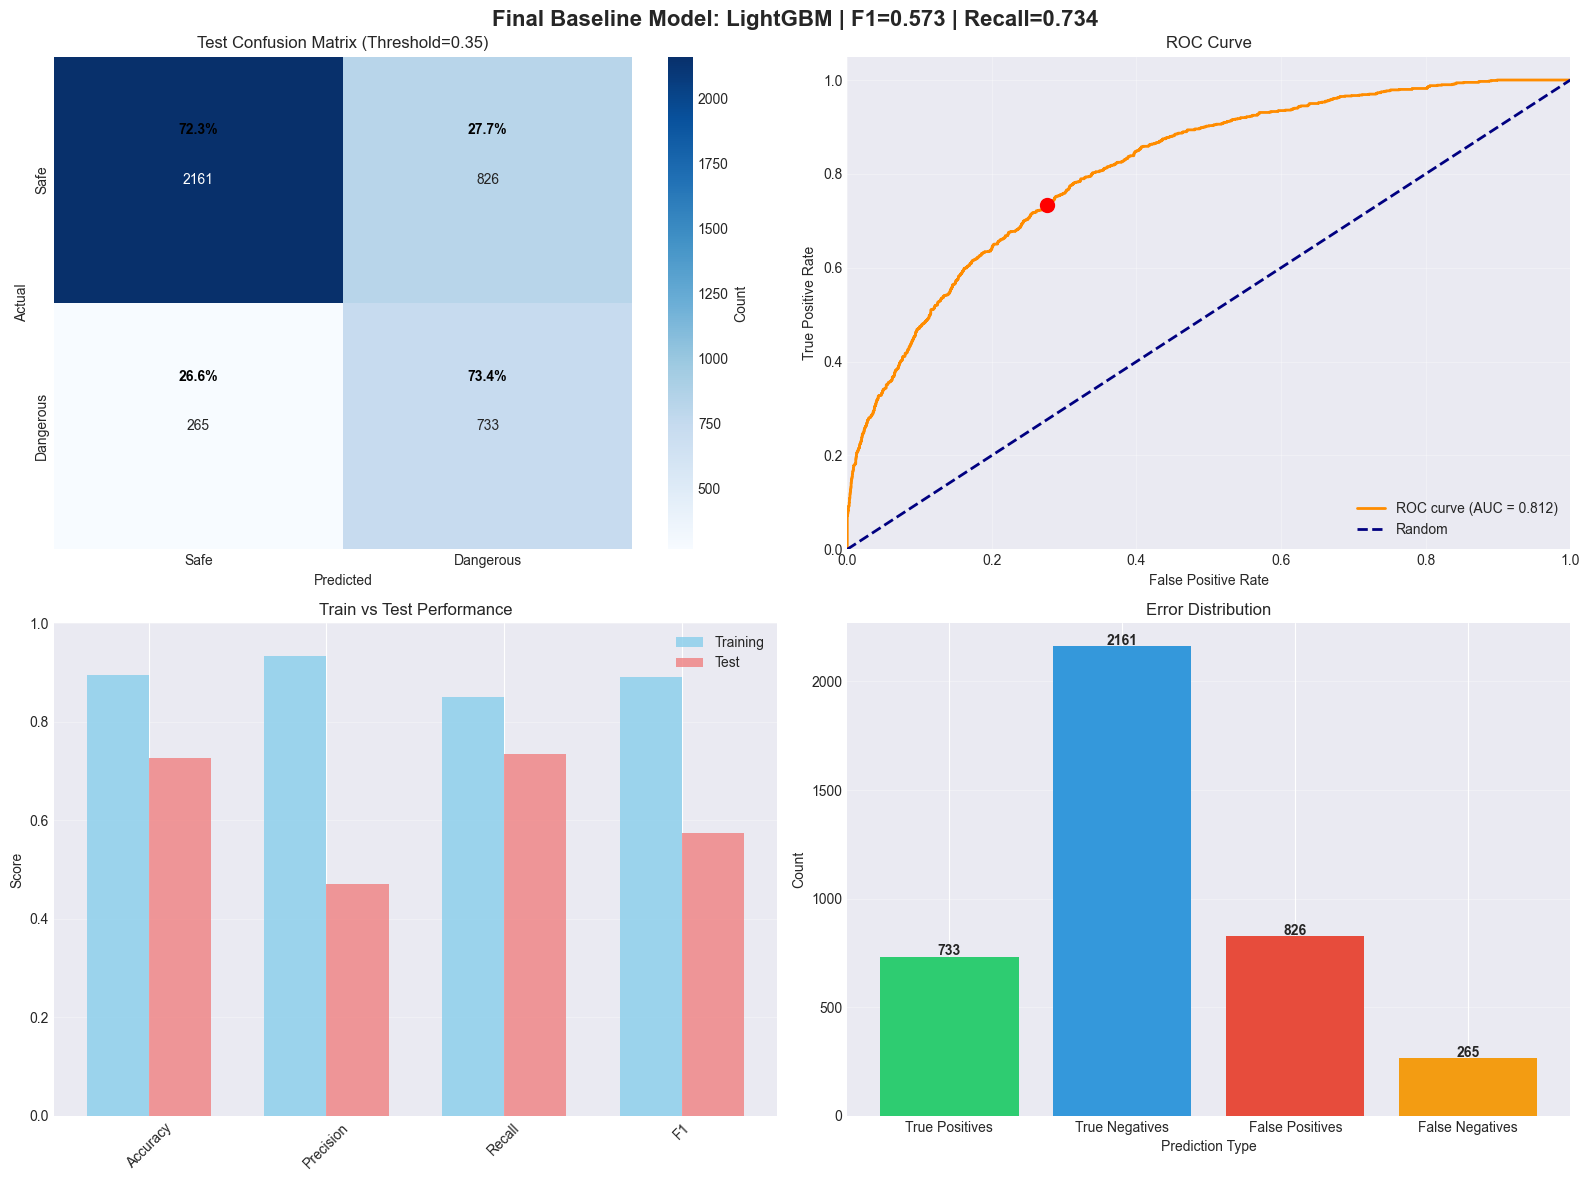

2026/02/05 15:24:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Final baseline model trained and evaluated
   Model saved to MLflow with run ID: a02f02905e664d13b2e5984e5edf632f
   Results saved to: analysis/model_training/final_baseline_results.csv
   Visualizations saved to MLflow artifacts


In [ ]:
print(f"\nTraining final baseline model with:")
print(f"   • Feature Set: {BEST_FEATURE_SET} ({BEST_N_FEATURES} features)")
print(f"   • Balancing: {BEST_BALANCING}")
print(f"   • Algorithm: {BEST_ALGORITHM}")
print(f"   • Threshold: {OPTIMAL_THRESHOLD:.2f}")

# Store final results
final_results = {}

with mlflow.start_run(run_name="Final_Baseline_Model", nested=True):
    # Log final configuration
    mlflow.log_param("experiment", "final_baseline")
    mlflow.log_param("feature_set", BEST_FEATURE_SET)
    mlflow.log_param("n_features", BEST_N_FEATURES)
    mlflow.log_param("balancing", BEST_BALANCING)
    mlflow.log_param("algorithm", BEST_ALGORITHM)
    mlflow.log_param("optimal_threshold", float(OPTIMAL_THRESHOLD))
    mlflow.log_param("test_evaluation", "first_and_only")
    
    # Load full training data (train + validation) and test data
    X_train_full, y_train_full, _, _, X_test, y_test = load_feature_set(
        BEST_FEATURE_SET, BEST_N_FEATURES, use_smote=USE_SMOTE
    )
    
    # Get the final model
    final_model_info = algorithms[BEST_ALGORITHM]
    final_model = final_model_info["model"]
    
    # Create a custom experiment that uses optimal threshold
    # First, train the model normally
    print("   Training final model...")
    pipeline = create_model_pipeline(BEST_ALGORITHM, final_model)
    pipeline.fit(X_train_full, y_train_full)
    
    # Make predictions with the trained pipeline
    y_proba_test = pipeline.predict_proba(X_test)[:, 1]
    y_pred_test = (y_proba_test >= OPTIMAL_THRESHOLD).astype(int)
    
    # Also predict on training data for overfitting analysis
    y_train_pred = pipeline.predict(X_train_full)
    y_train_proba = pipeline.predict_proba(X_train_full)[:, 1]
    
    # Calculate comprehensive metrics
    final_metrics = {
        "test_accuracy": accuracy_score(y_test, y_pred_test),
        "test_precision_dangerous": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
        "test_recall_dangerous": recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
        "test_f1_dangerous": f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
        "test_roc_auc": roc_auc_score(y_test, y_proba_test),
        
        # Training metrics for overfitting analysis
        "train_accuracy": accuracy_score(y_train_full, y_train_pred),
        "train_precision_dangerous": precision_score(y_train_full, y_train_pred, pos_label=1, zero_division=0),
        "train_recall_dangerous": recall_score(y_train_full, y_train_pred, pos_label=1, zero_division=0),
        "train_f1_dangerous": f1_score(y_train_full, y_train_pred, pos_label=1, zero_division=0),
        "train_roc_auc": roc_auc_score(y_train_full, y_train_proba),
        
        # Threshold-specific metrics
        "test_true_positives": ((y_pred_test == 1) & (y_test == 1)).sum(),
        "test_true_negatives": ((y_pred_test == 0) & (y_test == 0)).sum(),
        "test_false_positives": ((y_pred_test == 1) & (y_test == 0)).sum(),
        "test_false_negatives": ((y_pred_test == 0) & (y_test == 1)).sum(),
    }
    
    # Calculate overfitting gaps
    final_metrics["overfit_gap_f1"] = final_metrics["train_f1_dangerous"] - final_metrics["test_f1_dangerous"]
    final_metrics["overfit_gap_accuracy"] = final_metrics["train_accuracy"] - final_metrics["test_accuracy"]
    
    # Log final metrics
    for metric_name, metric_value in final_metrics.items():
        mlflow.log_metric(metric_name, float(metric_value))
    
    # Store results for summary
    final_results = final_metrics.copy()
    final_results['threshold'] = OPTIMAL_THRESHOLD
    
    # Create final evaluation report
    print("\n" + "="*60)
    print("FINAL BASELINE MODEL EVALUATION")
    print("="*60)
    print(f"Model: {BEST_ALGORITHM} with threshold={OPTIMAL_THRESHOLD:.2f}")
    print(f"\nTEST SET PERFORMANCE:")
    print(f"   Accuracy:          {final_metrics['test_accuracy']:.4f}")
    print(f"   Precision (Dangerous): {final_metrics['test_precision_dangerous']:.4f}")
    print(f"   Recall (Dangerous):    {final_metrics['test_recall_dangerous']:.4f}")
    print(f"   F1 (Dangerous):        {final_metrics['test_f1_dangerous']:.4f}")
    print(f"   ROC-AUC:           {final_metrics['test_roc_auc']:.4f}")
    
    print(f"\nTRAINING SET PERFORMANCE (for overfitting analysis):")
    print(f"   Train Accuracy:    {final_metrics['train_accuracy']:.4f}")
    print(f"   Train F1:          {final_metrics['train_f1_dangerous']:.4f}")
    print(f"   Overfit Gap (F1):  {final_metrics['overfit_gap_f1']:.4f} " 
          f"{'(GOOD)' if final_metrics['overfit_gap_f1'] < 0.1 else '(WARNING: Possible overfitting)'}")
    
    print(f"\nERROR ANALYSIS:")
    print(f"   False Positives:   {final_metrics['test_false_positives']} "
          f"(Safe drivers flagged as dangerous)")
    print(f"   False Negatives:   {final_metrics['test_false_negatives']} "
          f"(Dangerous drivers missed)")
    print(f"   True Positives:    {final_metrics['test_true_positives']} "
          f"(Dangerous drivers correctly identified)")
    print(f"   True Negatives:    {final_metrics['test_true_negatives']} "
          f"(Safe drivers correctly identified)")
    
    print("\nCLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred_test, 
                               target_names=['Safe', 'Dangerous'],
                               digits=4))
    
    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0], 
                cbar_kws={'label': 'Count'})
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    axes[0, 0].set_title(f'Test Confusion Matrix (Threshold={OPTIMAL_THRESHOLD:.2f})')
    axes[0, 0].set_xticklabels(['Safe', 'Dangerous'])
    axes[0, 0].set_yticklabels(['Safe', 'Dangerous'])
    
    # Add percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(2):
        for j in range(2):
            axes[0, 0].text(j+0.5, i+0.3, f"{cm_percent[i,j]:.1%}", 
                          ha='center', va='center', color='black', fontweight='bold')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba_test)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True, alpha=0.3)
    
    # Mark operating point (threshold)
    fp_rate = final_metrics['test_false_positives'] / (final_metrics['test_false_positives'] + final_metrics['test_true_negatives'])
    tp_rate = final_metrics['test_recall_dangerous']
    axes[0, 1].scatter(fp_rate, tp_rate, color='red', s=100, zorder=5, 
                      label=f'Operating Point (t={OPTIMAL_THRESHOLD:.2f})')
    
    # 3. Performance Comparison (Train vs Test)
    metrics_to_compare = ['accuracy', 'precision_dangerous', 'recall_dangerous', 'f1_dangerous']
    train_vals = [final_metrics[f'train_{m}'] for m in metrics_to_compare]
    test_vals = [final_metrics[f'test_{m}'] for m in metrics_to_compare]
    
    x = np.arange(len(metrics_to_compare))
    width = 0.35
    axes[1, 0].bar(x - width/2, train_vals, width, label='Training', color='skyblue', alpha=0.8)
    axes[1, 0].bar(x + width/2, test_vals, width, label='Test', color='lightcoral', alpha=0.8)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1'], rotation=45)
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Train vs Test Performance')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim([0, 1])
    
    # 4. Error Distribution
    error_types = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
    error_counts = [
        final_metrics['test_true_positives'],
        final_metrics['test_true_negatives'],
        final_metrics['test_false_positives'],
        final_metrics['test_false_negatives']
    ]
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
    
    axes[1, 1].bar(error_types, error_counts, color=colors)
    axes[1, 1].set_xlabel('Prediction Type')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(error_counts):
        axes[1, 1].text(i, v + 5, str(v), ha='center', fontweight='bold')
    
    plt.suptitle(f'Final Baseline Model: {BEST_ALGORITHM} | F1={final_metrics["test_f1_dangerous"]:.3f} | Recall={final_metrics["test_recall_dangerous"]:.3f}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save and log visualizations
    final_plot_path = "analysis/plots/model_training/final_baseline_summary.png"
    plt.savefig(final_plot_path, dpi=150, bbox_inches='tight')
    mlflow.log_artifact(final_plot_path, "final_evaluation")
    plt.show()
    plt.close()
    
    # Log final model
    mlflow.sklearn.log_model(pipeline, "final_model")
    
    # Save final results
    final_results_path = "analysis/model_training/final_baseline_results.csv"
    pd.DataFrame([final_results]).to_csv(final_results_path, index=False)
    mlflow.log_artifact(final_results_path, "final_results")
    
    print(f"\nFinal baseline model trained and evaluated")
    print(f"   Model saved to MLflow with run ID: {mlflow.active_run().info.run_id}")
    print(f"   Results saved to: {final_results_path}")
    print(f"   Visualizations saved to MLflow artifacts")

---

#### **Step 9: Experiment Summary**

---

In [71]:
# Create comprehensive experiment summary
experiment_summary = {
    "experiment_timestamp": datetime.now().isoformat(),
    "best_configuration": {
        "feature_set": BEST_FEATURE_SET,
        "n_features": BEST_N_FEATURES,
        "balancing_strategy": BEST_BALANCING,
        "use_smote": USE_SMOTE,
        "algorithm": BEST_ALGORITHM,
        "optimal_threshold": float(OPTIMAL_THRESHOLD)
    },
    "final_performance": final_metrics,
    "experiment_results": {
        "feature_set_comparison": exp1_df.to_dict('records'),
        "balancing_comparison": exp2_df.to_dict('records'),
        "algorithm_comparison": exp3_df.to_dict('records')
    },
    "methodology": {
        "validation_strategy": "train_val_split",
        "test_usage": "single_final_evaluation",
        "primary_metric": "f1_dangerous",
        "secondary_metric": "recall_dangerous",
        "threshold_optimization": "f_beta_with_beta_2"
    }
}

# Save summary
summary_path = "analysis/reports/model_training_experiment_summary.json"
with open(summary_path, 'w') as f:
    json.dump(experiment_summary, f, indent=2, default=str)

print(f"Saved experiment summary: {summary_path}")

Saved experiment summary: analysis/reports/model_training_experiment_summary.json


In [72]:
mlflow.end_run()